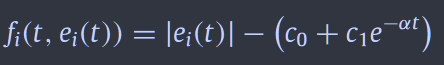

[ 0.55  0.4  -0.05 -0.1  -0.7 ]
实现了一致性，时间: 4.755999999999923
总触发次数: 110


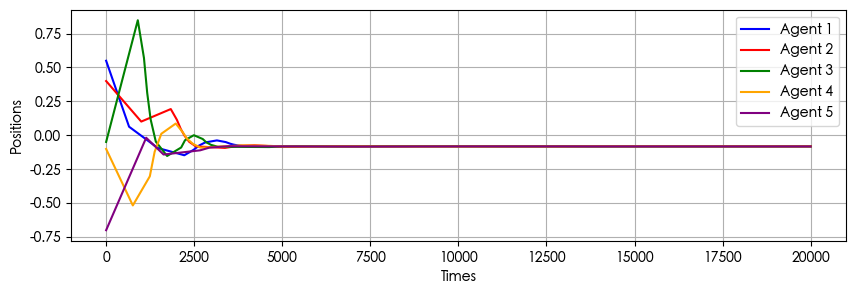

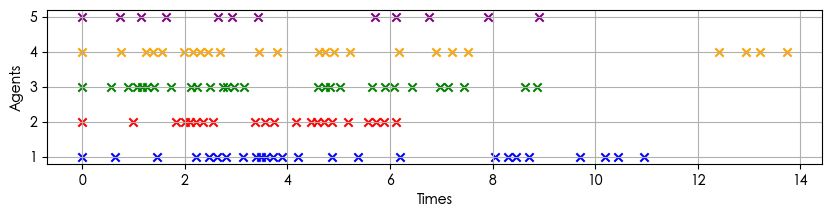

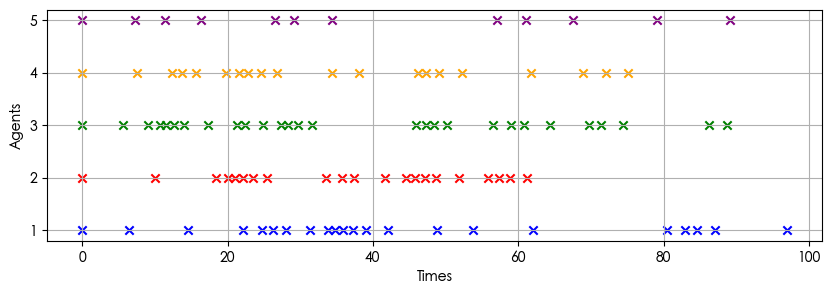

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

# 设置中文字体为macOS中的常见中文字体
rcParams['font.sans-serif'] = ['PingFang SC', 'Heiti TC', 'Arial Unicode MS']
rcParams['axes.unicode_minus'] = False  # 解决负号无法显示的问题

class Agent:
    def __init__(self, initial_position, index):
        self.position = initial_position
        self.index = index
        self.neighbors = []
        self.last_broadcast_position = self.position  #存储了该智能体最近一次广播的位置
        self.trigger_points = []
        self.u_i = 0
        # self.c_0 = 0.0001
        # self.c_1 = 0.2499
        # self.alpha = 0.4699
        self.c_0 = 0.00068
        self.c_1 = 1.2
        self.alpha = 1.4
        self.trigger_count = 0
        self.consensus_time = None  # 记录实现一致性的时间
        self.a = 0.005
         
    def add_neighbor(self, neighbor):
        if neighbor not in self.neighbors:
            self.neighbors.append(neighbor)
            neighbor.neighbors.append(self)

    def is_neighbor(self, agent):
        return agent in self.neighbors
    
    def update_position(self, t, dt):
        e_i = self.last_broadcast_position - self.position
        trigger_condition = np.abs(e_i) - (self.c_0 + self.c_1 * np.exp(- self.alpha * t))
        
        # 如果事件触发函数大于等于0，则更新位置
        if trigger_condition >= 0 or t == 0:
            self.u_i = - sum((self.last_broadcast_position - neighbor.last_broadcast_position) for neighbor in self.neighbors)
            self.position += self.u_i * dt
            self.last_broadcast_position = self.position
            #记录触发的相关信息
            self.trigger_points.append((t, self.position))
            self.trigger_count += 1
        else:
            self.position += self.u_i * dt

        # 检查一致性
        positions = np.array([agent.position for agent in agents])
        max_diff = np.max(positions) - np.min(positions)
        if max_diff <= self.a and self.consensus_time is None:
            self.consensus_time = t  # 更新一致性时间
        elif max_diff > self.a:
            self.consensus_time = None  # 失去一致性


# 初始化参数和智能体
num_agents = 5
num_iterations = 20
dt = 0.001
np.random.seed(0)
#agents = [Agent(np.random.uniform(-1, 1), i) for i in range(num_agents)]
#initial_positions = np.linspace(-1, 1, num_agents)
initial_positions = [0.55, 0.4, -0.05, -0.1, -0.7]
agents = [Agent(pos, i) for i, pos in enumerate(initial_positions)]  

print(np.array([agent.position for agent in agents]))

# 定义邻居关系
agents[0].add_neighbor(agents[1])
agents[0].add_neighbor(agents[2])
agents[1].add_neighbor(agents[2])
agents[2].add_neighbor(agents[3])
agents[3].add_neighbor(agents[4])

L = np.array([[ 2, -1, -1,  0,  0],
              [-1,  2, -1,  0,  0],
              [-1, -1,  3, -1,  0],
              [ 0,  0, -1,  2, -1],
              [ 0,  0,  0, -1,  1]])

# 计算拉普拉斯矩阵的特征值
eigenvalues = np.linalg.eigvalsh(L)
# 谱范数是所有特征值的绝对值中的最大值
spectral_norm = np.max(np.abs(eigenvalues))
# 第二小的特征值，也被称为网络的代数连通性
second_smallest_eigenvalue = np.partition(eigenvalues, 1)[1]

# 运行模拟
positions = np.zeros((int(num_iterations / dt), num_agents))  # 修改此行

t = 0
index = 0  # 新增此行
while index < int(num_iterations / dt):  # 修改此行
    for agent in agents:
        agent.update_position(t, dt)
        positions[index, agent.index] = agent.position  # 修改此行
    t += dt
    index += 1  # 新增此行

# 检查是否实现了一致性并输出结果
consensus_achieved = any(agent.consensus_time is not None for agent in agents)
if consensus_achieved:
    consensus_times = [agent.consensus_time for agent in agents if agent.consensus_time is not None]
    print(f"实现了一致性，时间: {max(consensus_times)}")
else:
    print("没有实现一致性")

trigger_counts = sum(len([point for point in agent.trigger_points]) for agent in agents)
print(f"总触发次数: {trigger_counts}")

# 手动指定每个智能体的颜色
colors = ['blue', 'red', 'green', 'orange', 'purple']  # 每个智能体的颜色

# 绘制结果图
plt.figure(figsize=(10, 3))
for i, agent in enumerate(agents):
    plt.plot(positions[:, i], label=f'Agent {i+1}', color=colors[i])
plt.xlabel('Times')
plt.ylabel('Positions')
#plt.title('智能体随时间变化的位置')
plt.legend()
plt.grid(True)

# 绘制触发事件图，确保智能体的触发事件颜色与其位置图中的颜色相匹配
plt.figure(figsize=(10, 2))
# 收集所有智能体的触发时间点和对应的索引
trigger_events = []
for i, agent in enumerate(agents):
    for t, _ in agent.trigger_points:
        trigger_events.append((t, i + 1, colors[i]))  # 存储时间、智能体索引和颜色
# 按触发时间排序
trigger_events.sort()
# 绘制触发事件
for t, i, color in trigger_events:
    plt.scatter(t, i, marker='x', color=color)  # 使用相应颜色绘制触发事件
plt.xlabel('Times')
plt.ylabel('Agents')
#plt.title('各智能体触发事件')
plt.yticks(range(1, num_agents + 1))  # 设置y轴刻度以匹配智能体的索引
plt.grid(True)

# 创建自定义的时间数组
time = 10
custom_time = np.arange(num_iterations) * dt

# 截取前50个时间步的数据
custom_time = custom_time[:time]

# 绘制触发事件图，使用截取后的时间数组
plt.figure(figsize=(10, 3))
# 收集所有智能体的触发时间点和对应的索引以及颜色
trigger_events = []
for i, agent in enumerate(agents):
    for t, _ in agent.trigger_points:
        if t < time:  # 仅保留时间步前50的触发事件数据
            trigger_events.append((t, i + 1, colors[i]))  # 存储时间、智能体索引和颜色
# 按触发时间排序
trigger_events.sort()
# 绘制触发事件
for t, i, color in trigger_events:
    plt.scatter(t * 10, i, marker='x', color=color)  # 使用之前生成的颜色映射绘制触发事件，保持颜色一致
plt.xlabel('Times')
plt.ylabel('Agents')
#plt.title('各智能体触发事件')
plt.yticks(range(1, num_agents + 1))  # 设置y轴刻度以匹配智能体的索引
plt.grid(True)
plt.show()


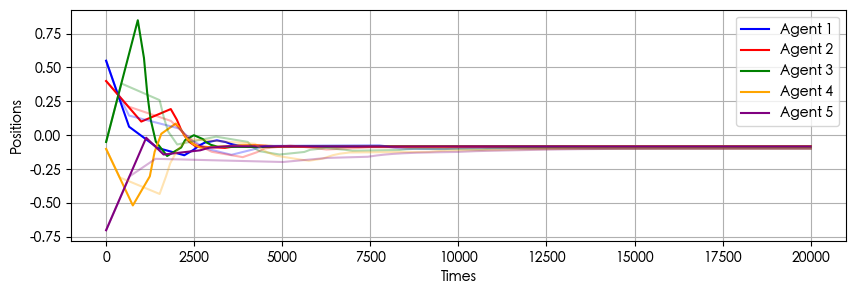

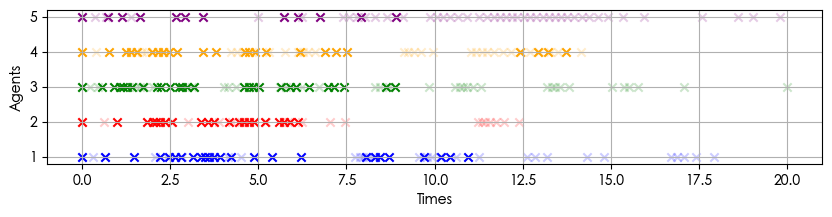

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

# 设置中文字体为macOS中的常见中文字体
rcParams['font.sans-serif'] = ['PingFang SC', 'Heiti TC', 'Arial Unicode MS']
rcParams['axes.unicode_minus'] = False  # 解决负号无法显示的问题

class Agent:
    def __init__(self, initial_position, index, c_0, c_1, alpha):
        self.position = initial_position
        self.index = index
        self.neighbors = []
        self.last_broadcast_position = self.position  #存储了该智能体最近一次广播的位置
        self.trigger_points = []
        self.u_i = 0
        self.c_0 = c_0
        self.c_1 = c_1
        self.alpha = alpha
        self.trigger_count = 0
        self.consensus_time = None  # 记录实现一致性的时间
        self.a = 0.005
         
    def add_neighbor(self, neighbor):
        if neighbor not in self.neighbors:
            self.neighbors.append(neighbor)
            neighbor.neighbors.append(self)

    def is_neighbor(self, agent):
        return agent in self.neighbors
    
    def update_position(self, t, dt):
        e_i = self.last_broadcast_position - self.position
        trigger_condition = np.abs(e_i) - (self.c_0 + self.c_1 * np.exp(- self.alpha * t))
        
        # 如果事件触发函数大于等于0，则更新位置
        if trigger_condition >= 0 or t == 0:
            self.u_i = - sum((self.last_broadcast_position - neighbor.last_broadcast_position) for neighbor in self.neighbors)
            self.position += self.u_i * dt
            self.last_broadcast_position = self.position
            #记录触发的相关信息
            self.trigger_points.append((t, self.position))
            self.trigger_count += 1
        else:
            self.position += self.u_i * dt

        # 检查一致性
        positions = np.array([agent.position for agent in agents])
        max_diff = np.max(positions) - np.min(positions)
        if max_diff <= self.a and self.consensus_time is None:
            self.consensus_time = t  # 更新一致性时间
        elif max_diff > self.a:
            self.consensus_time = None  # 失去一致性


# 初始化参数和智能体
num_agents = 5
num_iterations = 20
dt = 0.001
np.random.seed(0)

initial_positions = [0.55, 0.4, -0.05, -0.1, -0.7]

# 定义邻居关系
def setup_neighbors(agents):
    agents[0].add_neighbor(agents[1])
    agents[0].add_neighbor(agents[2])
    agents[1].add_neighbor(agents[2])
    agents[2].add_neighbor(agents[3])
    agents[3].add_neighbor(agents[4])

# 定义拉普拉斯矩阵
L = np.array([[ 2, -1, -1,  0,  0],
              [-1,  2, -1,  0,  0],
              [-1, -1,  3, -1,  0],
              [ 0,  0, -1,  2, -1],
              [ 0,  0,  0, -1,  1]])

# 计算拉普拉斯矩阵的特征值
eigenvalues = np.linalg.eigvalsh(L)
spectral_norm = np.max(np.abs(eigenvalues))
second_smallest_eigenvalue = np.partition(eigenvalues, 1)[1]

# 仿真不同参数设置
def simulate_agents(c_0, c_1, alpha, num_iterations, dt):
    agents = [Agent(pos, i, c_0, c_1, alpha) for i, pos in enumerate(initial_positions)]
    setup_neighbors(agents)

    positions = np.zeros((int(num_iterations / dt), num_agents))

    t = 0
    index = 0
    while index < int(num_iterations / dt):
        for agent in agents:
            agent.update_position(t, dt)
            positions[index, agent.index] = agent.position
        t += dt
        index += 1

    return positions, agents

# 运行第一组参数
positions_1, agents_1 = simulate_agents(c_0=0.00068, c_1=1.2, alpha=1.4, num_iterations=num_iterations, dt=dt)
# 运行第二组参数
positions_2, agents_2 = simulate_agents(c_0=0.0001, c_1=0.2499, alpha=0.4699, num_iterations=num_iterations, dt=dt)

# 手动指定每个智能体的颜色
colors = ['blue', 'red', 'green', 'orange', 'purple']  # 每个智能体的颜色

# 绘制结果图
plt.figure(figsize=(10, 3))
for i, agent in enumerate(agents_1):
    plt.plot(positions_1[:, i], label=f'Agent {i+1}', color=colors[i], linestyle='-')
for i, agent in enumerate(agents_2):
    plt.plot(positions_2[:, i],  color=colors[i], linestyle='-', alpha=0.3)
plt.xlabel('Times')
plt.ylabel('Positions')
plt.legend()
plt.grid(True)

# 绘制触发事件图
plt.figure(figsize=(10, 2))
trigger_events_1 = []
trigger_events_2 = []
for i, agent in enumerate(agents_1):
    for t, _ in agent.trigger_points:
        trigger_events_1.append((t, i + 1, colors[i]))
for i, agent in enumerate(agents_2):
    for t, _ in agent.trigger_points:
        trigger_events_2.append((t, i + 1, colors[i]))


# 绘制触发事件
trigger_events_1.sort()
trigger_events_2.sort()

# 绘制第一组参数的触发事件（实线）
for t, i, color in trigger_events_1:
    plt.scatter(t, i, marker='x', color=color)

# 绘制第二组参数的触发事件（虚线）
for t, i, color in trigger_events_2:
    plt.scatter(t, i, marker='x', color=color, alpha=0.2)

plt.xlabel('Times')
plt.ylabel('Agents')
plt.grid(True)

plt.show()

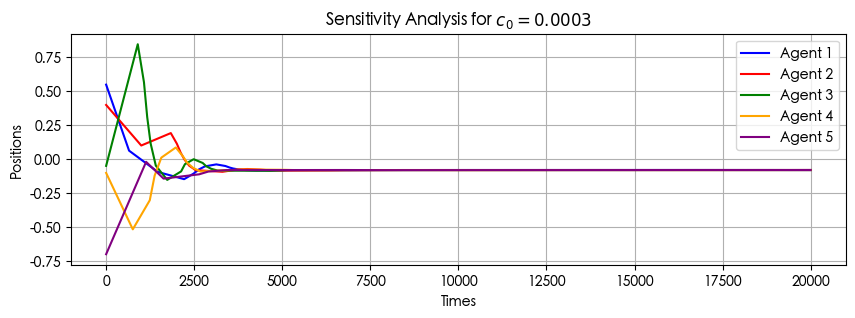

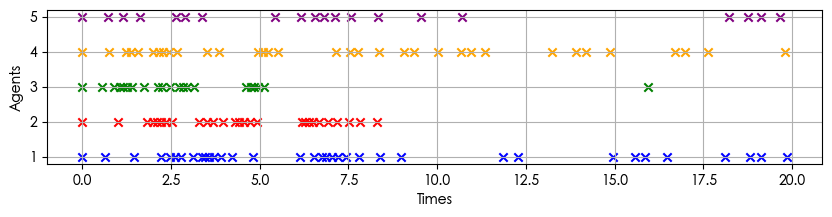

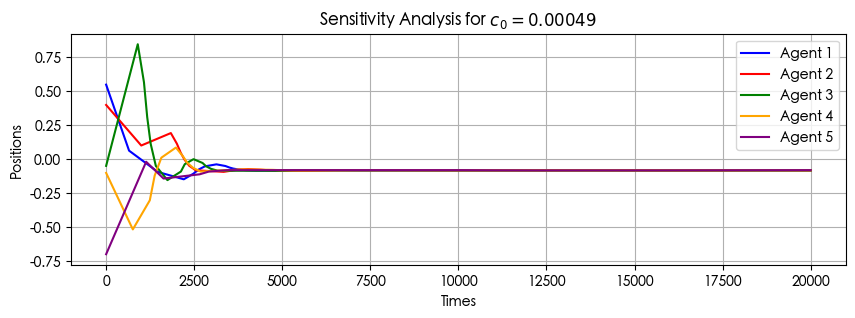

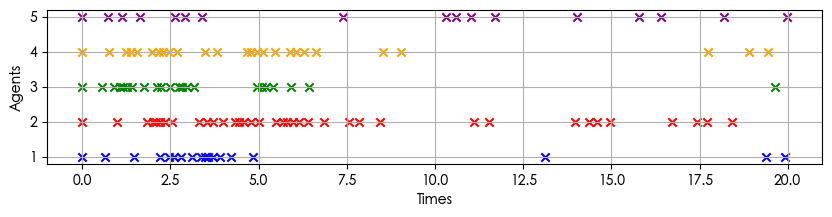

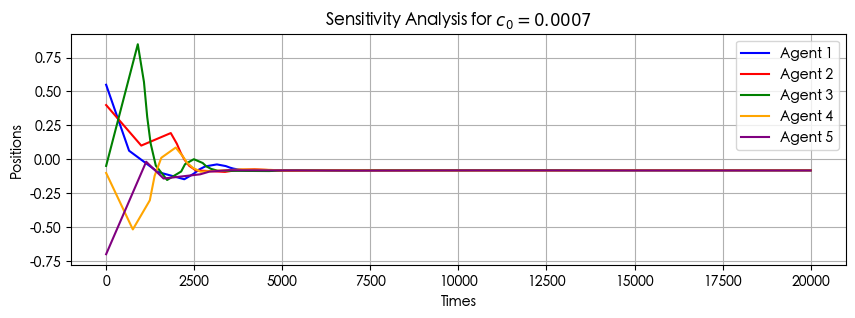

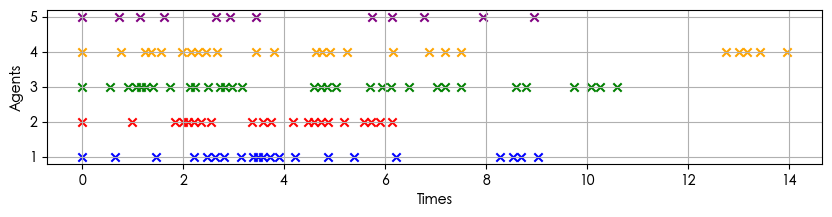

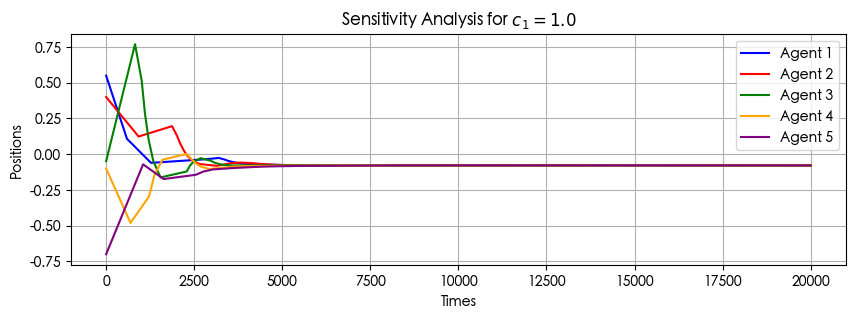

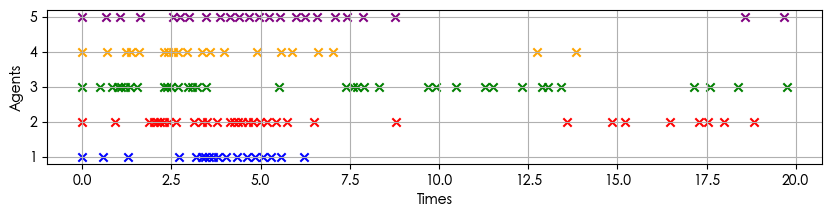

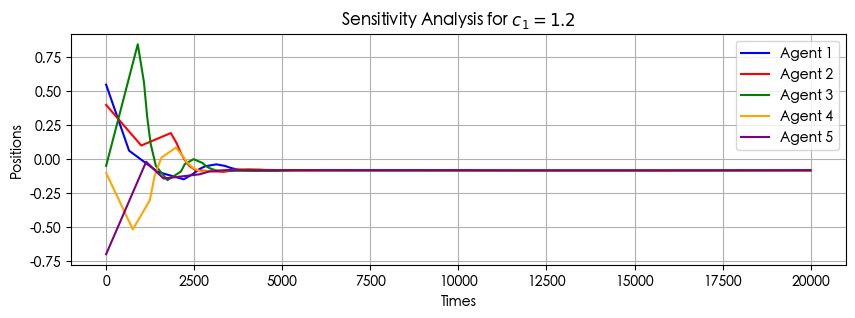

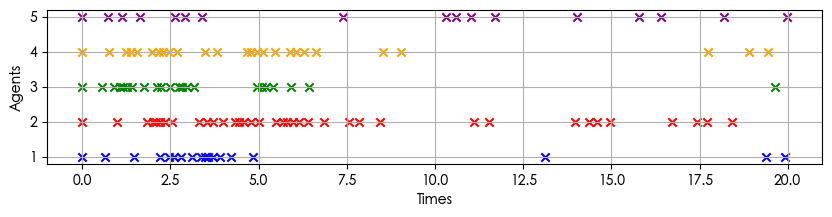

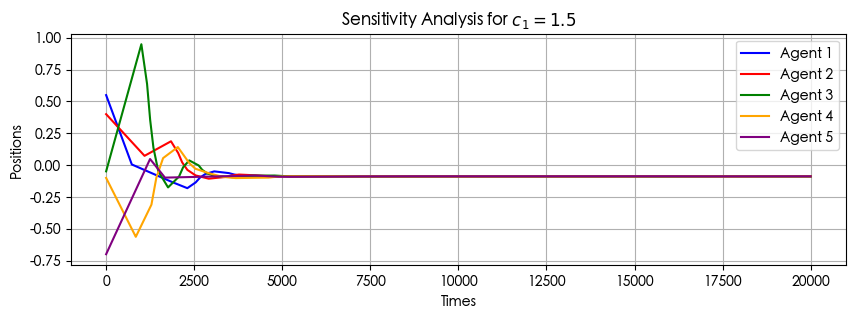

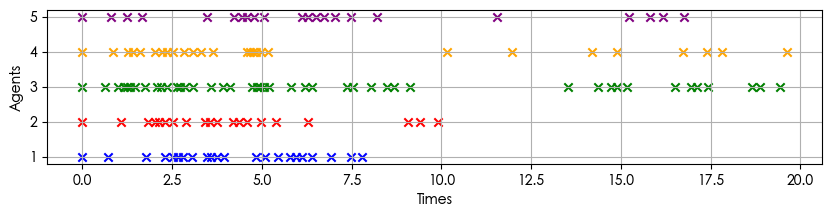

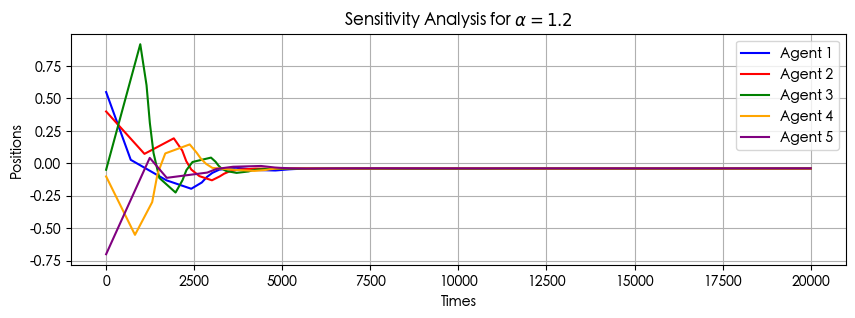

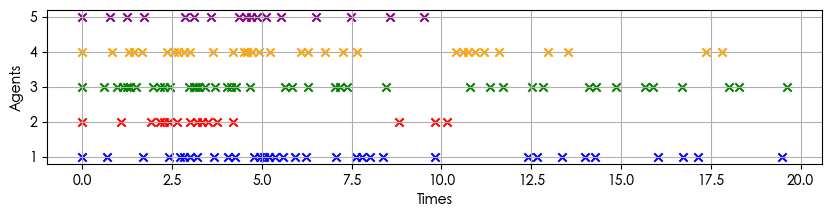

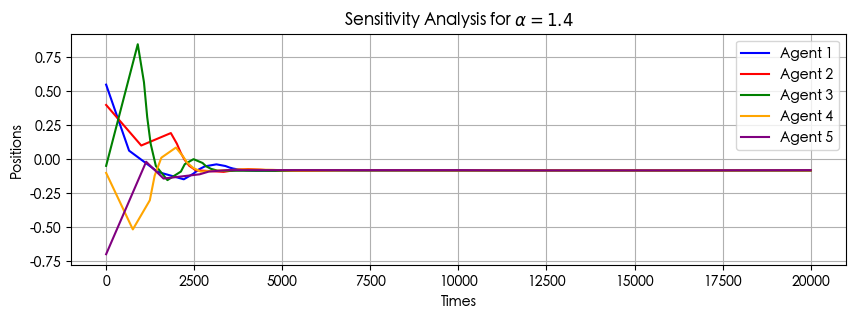

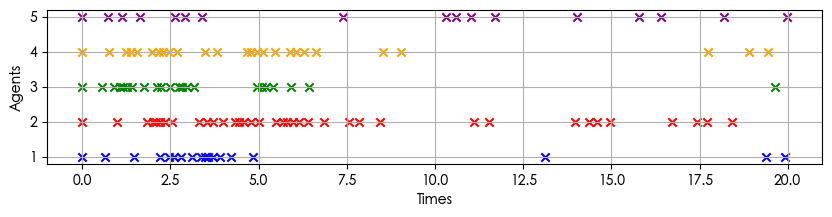

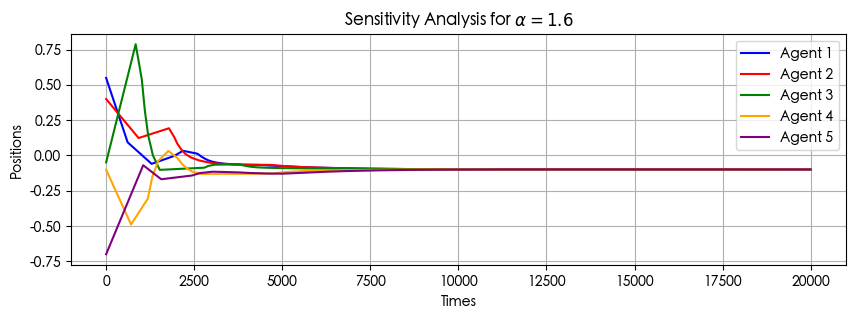

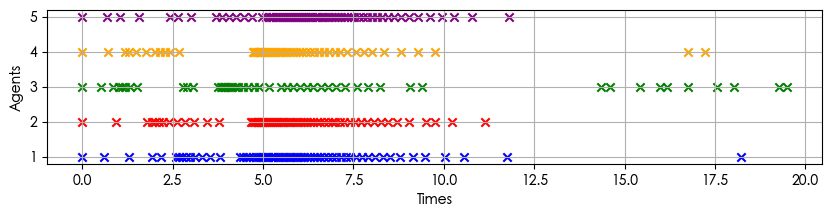

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

# 设置中文字体为macOS中的常见中文字体
rcParams['font.sans-serif'] = ['PingFang SC', 'Heiti TC', 'Arial Unicode MS']
rcParams['axes.unicode_minus'] = False  # 解决负号无法显示的问题

class Agent:
    def __init__(self, initial_position, index, c_0, c_1, alpha):
        self.position = initial_position
        self.index = index
        self.neighbors = []
        self.last_broadcast_position = self.position  #存储了该智能体最近一次广播的位置
        self.trigger_points = []
        self.u_i = 0
        self.c_0 = c_0
        self.c_1 = c_1
        self.alpha = alpha
        self.trigger_count = 0
        self.consensus_time = None  # 记录实现一致性的时间
        self.a = 0.005
         
    def add_neighbor(self, neighbor):
        if neighbor not in self.neighbors:
            self.neighbors.append(neighbor)
            neighbor.neighbors.append(self)

    def is_neighbor(self, agent):
        return agent in self.neighbors
    
    def update_position(self, t, dt):
        e_i = self.last_broadcast_position - self.position
        trigger_condition = np.abs(e_i) - (self.c_0 + self.c_1 * np.exp(- self.alpha * t))
        
        # 如果事件触发函数大于等于0，则更新位置
        if trigger_condition >= 0 or t == 0:
            self.u_i = - sum((self.last_broadcast_position - neighbor.last_broadcast_position) for neighbor in self.neighbors)
            self.position += self.u_i * dt
            self.last_broadcast_position = self.position
            #记录触发的相关信息
            self.trigger_points.append((t, self.position))
            self.trigger_count += 1
        else:
            self.position += self.u_i * dt

        # 检查一致性
        positions = np.array([agent.position for agent in agents])
        max_diff = np.max(positions) - np.min(positions)
        if max_diff <= self.a and self.consensus_time is None:
            self.consensus_time = t  # 更新一致性时间
        elif max_diff > self.a:
            self.consensus_time = None  # 失去一致性


def run_simulation(c_0, c_1, alpha, num_agents=5, num_iterations=20, dt=0.001):
    # 初始化智能体位置
    initial_positions = [0.55, 0.4, -0.05, -0.1, -0.7]
    agents = [Agent(pos, i, c_0, c_1, alpha) for i, pos in enumerate(initial_positions)]

    # 定义邻居关系
    agents[0].add_neighbor(agents[1])
    agents[0].add_neighbor(agents[2])
    agents[1].add_neighbor(agents[2])
    agents[2].add_neighbor(agents[3])
    agents[3].add_neighbor(agents[4])

    positions = np.zeros((int(num_iterations / dt), num_agents))  # 存储位置的数组
    t = 0
    index = 0
    while index < int(num_iterations / dt):
        for agent in agents:
            agent.update_position(t, dt)
            positions[index, agent.index] = agent.position
        t += dt
        index += 1
    
    # 返回模拟结果
    return agents, positions

def plot_results(agents, positions, title=""):
    # 手动指定每个智能体的颜色
    colors = ['blue', 'red', 'green', 'orange', 'purple']

    # 绘制结果图
    plt.figure(figsize=(10, 3))
    for i, agent in enumerate(agents):
        plt.plot(positions[:, i], label=f'Agent {i+1}', color=colors[i])
    plt.xlabel('Times')
    plt.ylabel('Positions')
    plt.title(title)
    plt.legend()
    plt.grid(True)

    # 绘制触发事件图，确保智能体的触发事件颜色与其位置图中的颜色相匹配
    plt.figure(figsize=(10, 2))
    trigger_events = []
    for i, agent in enumerate(agents):
        for t, _ in agent.trigger_points:
            trigger_events.append((t, i + 1, colors[i]))  # 存储时间、智能体索引和颜色
    # 按触发时间排序
    trigger_events.sort()
    # 绘制触发事件
    for t, i, color in trigger_events:
        plt.scatter(t, i, marker='x', color=color)  # 使用相应颜色绘制触发事件
    plt.xlabel('Times')
    plt.ylabel('Agents')
    plt.yticks(range(1, len(agents) + 1))  # 设置y轴刻度以匹配智能体的索引
    plt.grid(True)
    plt.show()

# 执行敏感性分析，分别对 c_0, c_1 和 alpha 进行敏感性分析
c_0_values = [0.0003, 0.00049, 0.0007]
c_1_values = [1.0, 1.2, 1.5]
alpha_values = [1.2, 1.4, 1.6]

# 对 c_0 进行敏感性分析
for c_0 in c_0_values:
    agents, positions = run_simulation(c_0=c_0, c_1=1.2, alpha=1.4)
    plot_results(agents, positions, title=f'Sensitivity Analysis for $c_0 = {c_0}$')

# 对 c_1 进行敏感性分析
for c_1 in c_1_values:
    agents, positions = run_simulation(c_0=0.00049, c_1=c_1, alpha=1.4)
    plot_results(agents, positions, title=f'Sensitivity Analysis for $c_1 = {c_1}$')

# 对 alpha 进行敏感性分析
for alpha in alpha_values:
    agents, positions = run_simulation(c_0=0.00049, c_1=1.2, alpha=alpha)
    plot_results(agents, positions, title=f'Sensitivity Analysis for $\\alpha = {alpha}$')

[ 0.1   0.56  0.14 -0.24 -0.6 ]
2.000000000000001
实现了一致性，时间: 3.994999999999671
总触发次数: 146


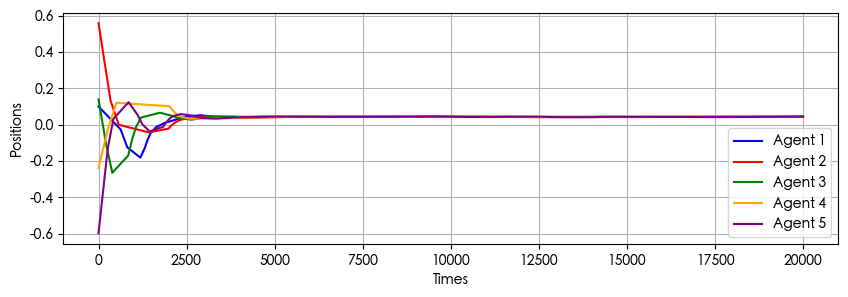

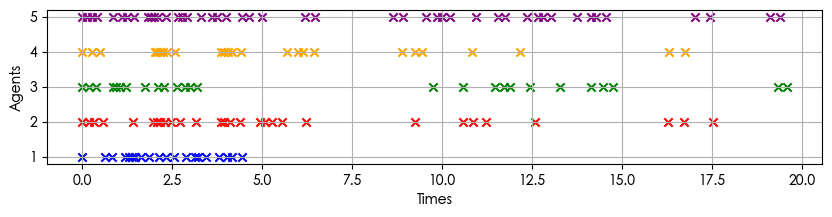

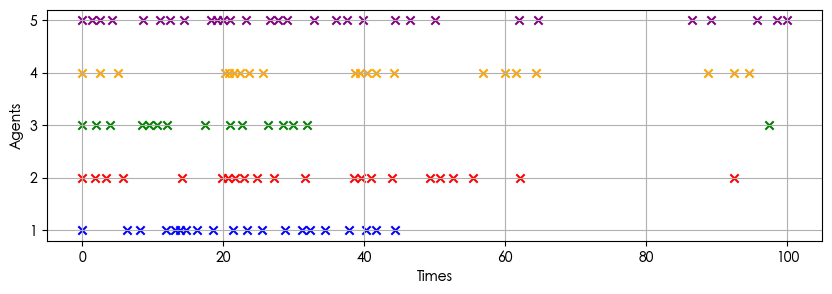

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

# 设置中文字体为macOS中的常见中文字体
rcParams['font.sans-serif'] = ['PingFang SC', 'Heiti TC', 'Arial Unicode MS']
rcParams['axes.unicode_minus'] = False  # 解决负号无法显示的问题

class Agent:
    def __init__(self, initial_position, index):
        self.position = initial_position
        self.index = index
        self.neighbors = []
        self.last_broadcast_position = self.position  #存储了该智能体最近一次广播的位置
        self.trigger_points = []
        self.u_i = 0
        self.c_0 = 0.00089
        self.c_1 = 0.3
        self.alpha = 1.4
        self.trigger_count = 0
        self.consensus_time = None  # 记录实现一致性的时间
        self.a = 0.005
         
    def add_neighbor(self, neighbor):
        if neighbor not in self.neighbors:
            self.neighbors.append(neighbor)
            neighbor.neighbors.append(self)

    def is_neighbor(self, agent):
        return agent in self.neighbors
    
    def update_position(self, t, dt):
        e_i = self.last_broadcast_position - self.position
        trigger_condition = np.abs(e_i) - (self.c_0 + self.c_1 * np.exp(- self.alpha * t))
        
        # 如果事件触发函数大于等于0，则更新位置
        if trigger_condition >= 0 or t == 0:
            self.u_i = - sum((self.last_broadcast_position - neighbor.last_broadcast_position) for neighbor in self.neighbors)
            self.position += self.u_i * dt
            self.last_broadcast_position = self.position
            #记录触发的相关信息
            self.trigger_points.append((t, self.position))
            self.trigger_count += 1
        else:
            self.position += self.u_i * dt

        # 检查一致性
        positions = np.array([agent.position for agent in agents])
        max_diff = np.max(positions) - np.min(positions)
        if max_diff <= self.a and self.consensus_time is None:
            self.consensus_time = t  # 更新一致性时间
        elif max_diff > self.a:
            self.consensus_time = None  # 失去一致性


# 初始化参数和智能体
num_agents = 5
num_iterations = 20
dt = 0.001
np.random.seed(0)
#agents = [Agent(np.random.uniform(-1, 1), i) for i in range(num_agents)]
#initial_positions = np.linspace(-1, 1, num_agents)
initial_positions = [0.1, 0.56, 0.14, -0.24, -0.6]
agents = [Agent(pos, i) for i, pos in enumerate(initial_positions)]  

print(np.array([agent.position for agent in agents]))

# 定义邻居关系
agents[0].add_neighbor(agents[1])
agents[0].add_neighbor(agents[2])
agents[0].add_neighbor(agents[4])
agents[1].add_neighbor(agents[3])
agents[2].add_neighbor(agents[3])
agents[2].add_neighbor(agents[4])
agents[3].add_neighbor(agents[4])



L = np.array([[ 3, -1, -1,  0, -1],
[-1,  2,  0, -1,  0],
[-1,  0,  3, -1, -1],
[ 0, -1, -1,  3, -1],
[-1,  0, -1, -1,  3]])

# 计算拉普拉斯矩阵的特征值
eigenvalues = np.linalg.eigvalsh(L)
# 谱范数是所有特征值的绝对值中的最大值
spectral_norm = np.max(np.abs(eigenvalues))
# 第二小的特征值，也被称为网络的代数连通性
second_smallest_eigenvalue = np.partition(eigenvalues, 1)[1]
print(second_smallest_eigenvalue)


# 运行模拟
positions = np.zeros((int(num_iterations / dt), num_agents))  # 修改此行

t = 0
index = 0  # 新增此行
while index < int(num_iterations / dt):  # 修改此行
    for agent in agents:
        agent.update_position(t, dt)
        positions[index, agent.index] = agent.position  # 修改此行
    t += dt
    index += 1  # 新增此行

# 检查是否实现了一致性并输出结果
consensus_achieved = any(agent.consensus_time is not None for agent in agents)
if consensus_achieved:
    consensus_times = [agent.consensus_time for agent in agents if agent.consensus_time is not None]
    print(f"实现了一致性，时间: {max(consensus_times)}")
else:
    print("没有实现一致性")

trigger_counts = sum(len([point for point in agent.trigger_points ]) for agent in agents)
print(f"总触发次数: {trigger_counts}")

# 手动指定每个智能体的颜色
colors = ['blue', 'red', 'green', 'orange', 'purple']  # 每个智能体的颜色


# 绘制结果图
plt.figure(figsize=(10, 3))
for i, agent in enumerate(agents):
    plt.plot(positions[:, i], label=f'Agent {i+1}', color=colors[i])
plt.xlabel('Times')
plt.ylabel('Positions')
#plt.title('智能体随时间变化的位置')
plt.legend()
plt.grid(True)



# 绘制触发事件图，确保智能体的触发事件颜色与其位置图中的颜色相匹配
plt.figure(figsize=(10, 2))
# 收集所有智能体的触发时间点和对应的索引
trigger_events = []
for i, agent in enumerate(agents):
    for t, _ in agent.trigger_points:
        trigger_events.append((t, i + 1, colors[i]))  # 存储时间、智能体索引和颜色
# 按触发时间排序
trigger_events.sort()
# 绘制触发事件
for t, i, color in trigger_events:
    plt.scatter(t, i, marker='x', color=color)  # type: ignore # 使用相应颜色绘制触发事件
plt.xlabel('Times')
plt.ylabel('Agents')
#plt.title('各智能体触发事件')
plt.yticks(range(1, num_agents + 1))  # 设置y轴刻度以匹配智能体的索引
plt.grid(True)



# 创建自定义的时间数组
time = 10
custom_time = np.arange(num_iterations) * dt

# 截取前50个时间步的数据
custom_time = custom_time[:time]

# 绘制触发事件图，使用截取后的时间数组
plt.figure(figsize=(10, 3))
# 收集所有智能体的触发时间点和对应的索引以及颜色
trigger_events = []
for i, agent in enumerate(agents):
    for t, _ in agent.trigger_points:
        if t < time:  # 仅保留时间步前50的触发事件数据
            trigger_events.append((t, i + 1, colors[i]))  # 存储时间、智能体索引和颜色
# 按触发时间排序
trigger_events.sort()
# 绘制触发事件
for t, i, color in trigger_events:
    plt.scatter(t * 10, i, marker='x', color=color)  # 使用之前生成的颜色映射绘制触发事件，保持颜色一致
plt.xlabel('Times')
plt.ylabel('Agents')
#plt.title('各智能体触发事件')
plt.yticks(range(1, num_agents + 1))  # 设置y轴刻度以匹配智能体的索引
plt.grid(True)
plt.show()

[ 0.23  0.88 -0.34 -0.67]
2.000000000000001
实现了一致性，时间: 4.021999999999678
总触发次数: 122


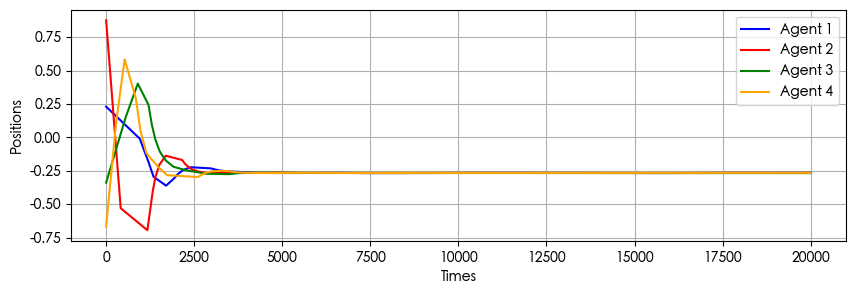

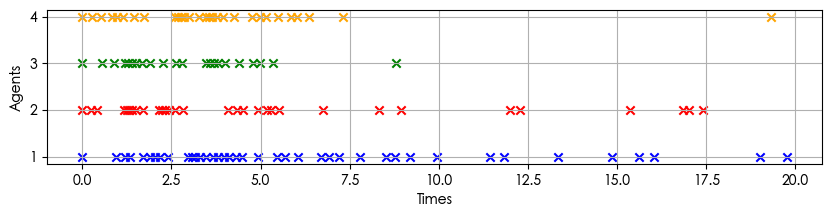

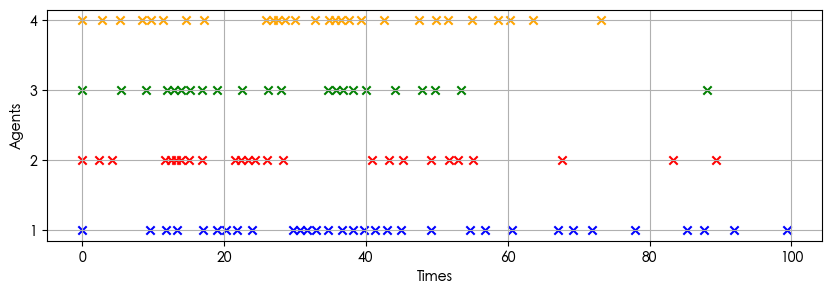

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

# 设置中文字体为macOS中的常见中文字体
rcParams['font.sans-serif'] = ['PingFang SC', 'Heiti TC', 'Arial Unicode MS']
rcParams['axes.unicode_minus'] = False  # 解决负号无法显示的问题

class Agent:
    def __init__(self, initial_position, index):
        self.position = initial_position
        self.index = index
        self.neighbors = []
        self.last_broadcast_position = self.position  #存储了该智能体最近一次广播的位置
        self.trigger_points = []
        self.u_i = 0
        self.c_0 = 0.00065
        self.c_1 = 1.2
        self.alpha = 1.7
        self.trigger_count = 0
        self.consensus_time = None  # 记录实现一致性的时间
        self.a = 0.005
         
    def add_neighbor(self, neighbor):
        if neighbor not in self.neighbors:
            self.neighbors.append(neighbor)
            neighbor.neighbors.append(self)

    def is_neighbor(self, agent):
        return agent in self.neighbors
    
    def update_position(self, t, dt):
        e_i = self.last_broadcast_position - self.position
        trigger_condition = np.abs(e_i) - (self.c_0 + self.c_1 * np.exp(- self.alpha * t))
        
        # 如果事件触发函数大于等于0，则更新位置
        if trigger_condition >= 0 or t == 0:
            self.u_i = - sum((self.last_broadcast_position - neighbor.last_broadcast_position) for neighbor in self.neighbors)
            self.position += self.u_i * dt
            self.last_broadcast_position = self.position
            #记录触发的相关信息
            self.trigger_points.append((t, self.position))
            self.trigger_count += 1
        else:
            self.position += self.u_i * dt

        # 检查一致性
        positions = np.array([agent.position for agent in agents])
        max_diff = np.max(positions) - np.min(positions)
        if max_diff <= self.a and self.consensus_time is None:
            self.consensus_time = t  # 更新一致性时间
        elif max_diff > self.a:
            self.consensus_time = None  # 失去一致性


# 初始化参数和智能体
num_agents = 4
num_iterations = 20
dt = 0.001
np.random.seed(0)
#agents = [Agent(np.random.uniform(-1, 1), i) for i in range(num_agents)]
#initial_positions = np.linspace(-1, 1, num_agents)
initial_positions = [0.23, 0.88, -0.34, -0.67]
agents = [Agent(pos, i) for i, pos in enumerate(initial_positions)]  

print(np.array([agent.position for agent in agents]))

# 定义邻居关系
agents[0].add_neighbor(agents[1])
agents[0].add_neighbor(agents[3])
agents[1].add_neighbor(agents[2])
agents[1].add_neighbor(agents[3])
agents[2].add_neighbor(agents[3])




L = np.array([[ 3, -1, -1,  0, -1],
[-1,  2,  0, -1,  0],
[-1,  0,  3, -1, -1],
[ 0, -1, -1,  3, -1],
[-1,  0, -1, -1,  3]])

# 计算拉普拉斯矩阵的特征值
eigenvalues = np.linalg.eigvalsh(L)
# 谱范数是所有特征值的绝对值中的最大值
spectral_norm = np.max(np.abs(eigenvalues))
# 第二小的特征值，也被称为网络的代数连通性
second_smallest_eigenvalue = np.partition(eigenvalues, 1)[1]
print(second_smallest_eigenvalue)


# 运行模拟
positions = np.zeros((int(num_iterations / dt), num_agents))  # 修改此行

t = 0
index = 0  # 新增此行
while index < int(num_iterations / dt):  # 修改此行
    for agent in agents:
        agent.update_position(t, dt)
        positions[index, agent.index] = agent.position  # 修改此行
    t += dt
    index += 1  # 新增此行

# 检查是否实现了一致性并输出结果
consensus_achieved = any(agent.consensus_time is not None for agent in agents)
if consensus_achieved:
    consensus_times = [agent.consensus_time for agent in agents if agent.consensus_time is not None]
    print(f"实现了一致性，时间: {max(consensus_times)}")
else:
    print("没有实现一致性")

trigger_counts = sum(len([point for point in agent.trigger_points ]) for agent in agents)
print(f"总触发次数: {trigger_counts}")

# 手动指定每个智能体的颜色
colors = ['blue', 'red', 'green', 'orange', 'purple']  # 每个智能体的颜色


# 绘制结果图
plt.figure(figsize=(10, 3))
for i, agent in enumerate(agents):
    plt.plot(positions[:, i], label=f'Agent {i+1}', color=colors[i])
plt.xlabel('Times')
plt.ylabel('Positions')
#plt.title('智能体随时间变化的位置')
plt.legend()
plt.grid(True)



# 绘制触发事件图，确保智能体的触发事件颜色与其位置图中的颜色相匹配
plt.figure(figsize=(10, 2))
# 收集所有智能体的触发时间点和对应的索引
trigger_events = []
for i, agent in enumerate(agents):
    for t, _ in agent.trigger_points:
        trigger_events.append((t, i + 1, colors[i]))  # 存储时间、智能体索引和颜色
# 按触发时间排序
trigger_events.sort()
# 绘制触发事件
for t, i, color in trigger_events:
    plt.scatter(t, i, marker='x', color=color)  # type: ignore # 使用相应颜色绘制触发事件
plt.xlabel('Times')
plt.ylabel('Agents')
#plt.title('各智能体触发事件')
plt.yticks(range(1, num_agents + 1))  # 设置y轴刻度以匹配智能体的索引
plt.grid(True)


# 创建自定义的时间数组
time = 10
custom_time = np.arange(num_iterations) * dt

# 截取前50个时间步的数据
custom_time = custom_time[:time]

# 绘制触发事件图，使用截取后的时间数组
plt.figure(figsize=(10, 3))
# 收集所有智能体的触发时间点和对应的索引以及颜色
trigger_events = []
for i, agent in enumerate(agents):
    for t, _ in agent.trigger_points:
        if t < time:  # 仅保留时间步前50的触发事件数据
            trigger_events.append((t, i + 1, colors[i]))  # 存储时间、智能体索引和颜色
# 按触发时间排序
trigger_events.sort()
# 绘制触发事件
for t, i, color in trigger_events:
    plt.scatter(t * 10, i, marker='x', color=color)  # 使用之前生成的颜色映射绘制触发事件，保持颜色一致
plt.xlabel('Times')
plt.ylabel('Agents')
#plt.title('各智能体触发事件')
plt.yticks(range(1, num_agents + 1))  # 设置y轴刻度以匹配智能体的索引
plt.grid(True)
plt.show()

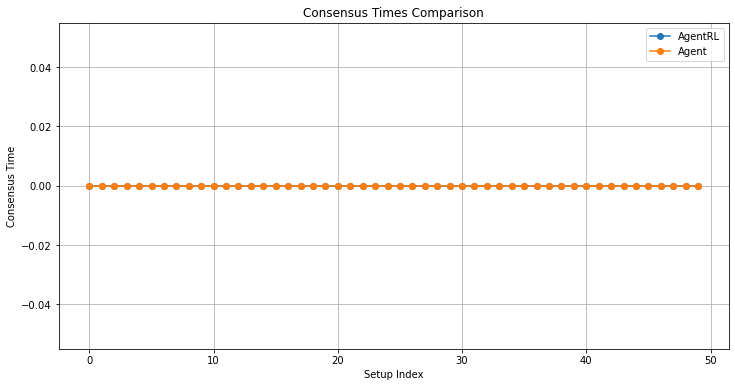

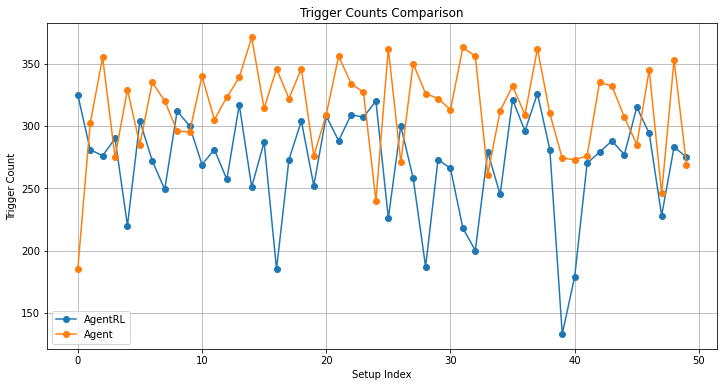

In [51]:
import numpy as np
import matplotlib.pyplot as plt

# 定义 Agent 类
class Agent:
    def __init__(self, initial_position, index):
        self.position = initial_position
        self.index = index
        self.neighbors = []
        self.last_broadcast_position = self.position
        self.trigger_points = []
        self.u_i = 0
        self.c_0 = 0.0004
        self.c_1 = 0.6
        self.alpha = 0.3
        self.trigger_count = 0
        self.consensus_time = None
        self.a = 0.005

    def add_neighbor(self, neighbor):
        if neighbor not in self.neighbors:
            self.neighbors.append(neighbor)
            neighbor.neighbors.append(self)

    def is_neighbor(self, agent):
        return agent in self.neighbors
    
    def update_position(self, t, dt):
        e_i = self.last_broadcast_position - self.position
        trigger_condition = np.abs(e_i) - (self.c_0 + self.c_1 * np.exp(-self.alpha * t))
        if trigger_condition >= 0 or t == 0:
            self.u_i = - sum(self.is_neighbor(neighbor) * (self.last_broadcast_position - neighbor.last_broadcast_position) for neighbor in self.neighbors)
            self.position += self.u_i * dt
            self.last_broadcast_position = self.position
            self.trigger_points.append((t, self.position))
            self.trigger_count += 1
        else:
            self.position += self.u_i * dt
        # 检查一致性
        positions = np.array([agent.position for agent in agents])
        max_diff = np.max(positions) - np.min(positions)
        if max_diff <= self.a and self.consensus_time is None:
            self.consensus_time = t  # 更新一致性时间
        elif max_diff > self.a:
            self.consensus_time = None  # 失去一致性

# 创建 Agent1 类，逻辑与 Agent 类似
class Agent1(Agent):
    def __init__(self, initial_position, index):
        super().__init__(initial_position, index)
        self.c_0 = 0.0001
        self.c_1 = 0.2499
        self.alpha = 0.4669

# 封装模拟函数
def simulate(agent_class, num_agents=5, num_iterations=200, dt=0.1, num_setups=50):
    consensus_times = []
    trigger_counts = []

    for _ in range(num_setups):
        initial_positions = np.random.uniform(-10, 10, num_agents)
        agents = [agent_class(pos, i) for i, pos in enumerate(initial_positions)]
        agents[0].add_neighbor(agents[1])
        agents[0].add_neighbor(agents[2])
        agents[1].add_neighbor(agents[2])
        agents[2].add_neighbor(agents[3])
        agents[3].add_neighbor(agents[4])

        for t in range(num_iterations):
            for agent in agents:
                agent.update_position(t, dt)

        # 检查是否实现了一致性并输出结果

        consensus_achieved = any(agent.consensus_time is not None for agent in agents)
        if consensus_achieved:
            consensus_time = [agent.consensus_time for agent in agents]
            consensus_timee = max(consensus_time)   
            #print(consensus_time)
        else:
            consensus_timee = 0
            
        consensus_times.append(consensus_timee)
        trigger_counts.append(sum(agent.trigger_count for agent in agents))
        

    return consensus_times, trigger_counts

# 运行模拟
consensus_times_agent, trigger_counts_agent = simulate(Agent)
consensus_times_agent1, trigger_counts_agent1 = simulate(Agent1)

# 绘制比较图
plt.figure(figsize=(12, 6))
plt.plot(consensus_times_agent, label='AgentRL', marker='o', linestyle='-')
plt.plot(consensus_times_agent1, label='Agent', marker='o', linestyle='-')
plt.title('Consensus Times Comparison')
plt.xlabel('Setup Index')
plt.ylabel('Consensus Time')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(trigger_counts_agent, label='AgentRL', marker='o', linestyle='-')
plt.plot(trigger_counts_agent1, label='Agent', marker='o', linestyle='-')
plt.title('Trigger Counts Comparison')
plt.xlabel('Setup Index')
plt.ylabel('Trigger Count')
plt.legend()
plt.grid(True)
plt.show()


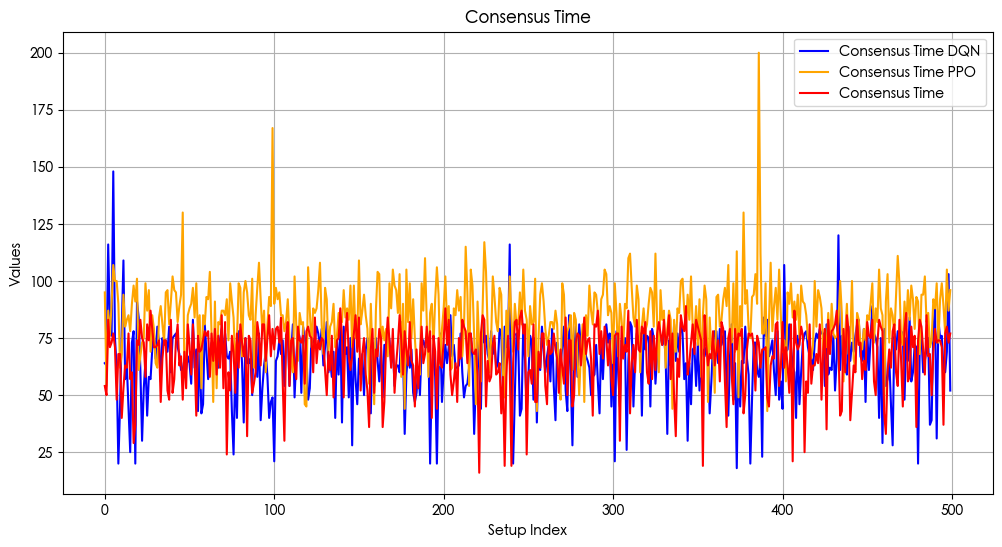

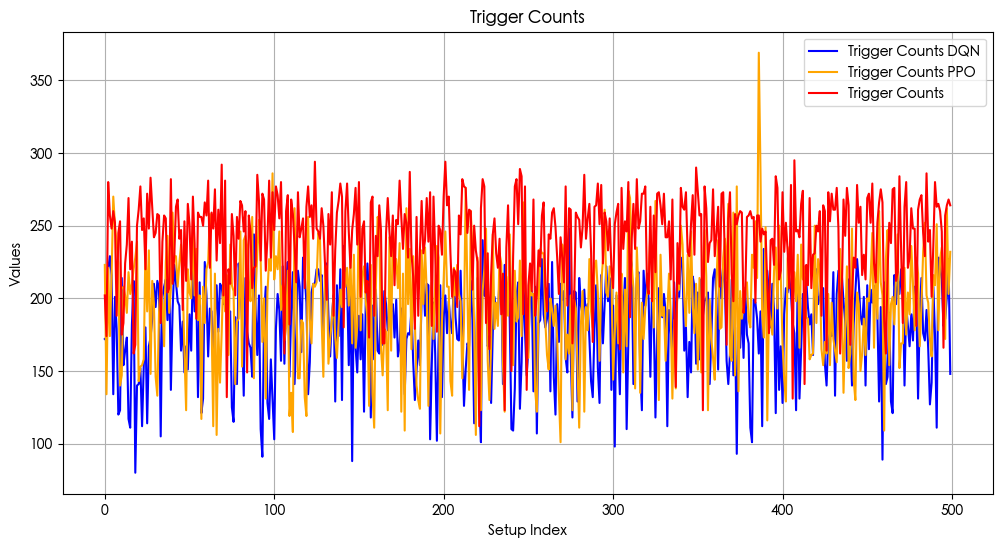

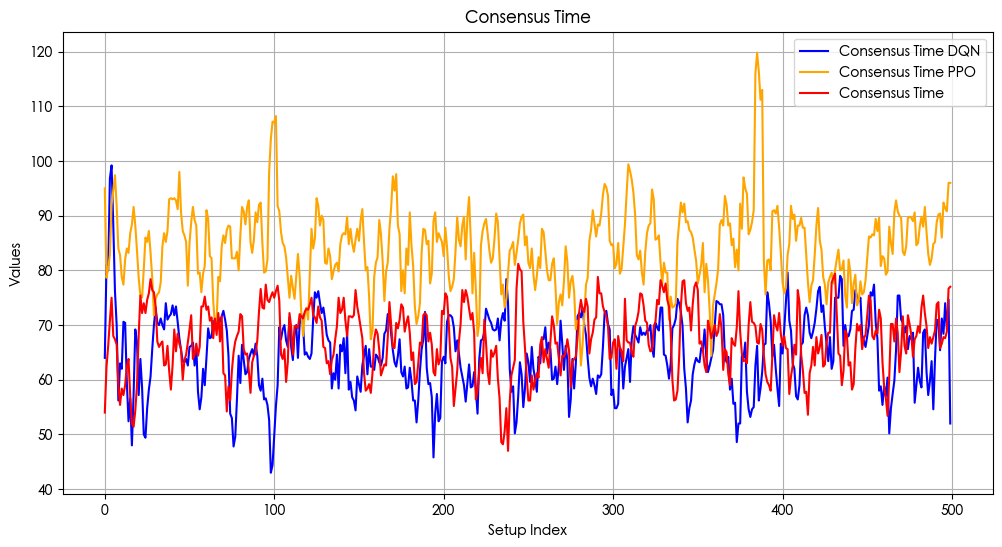

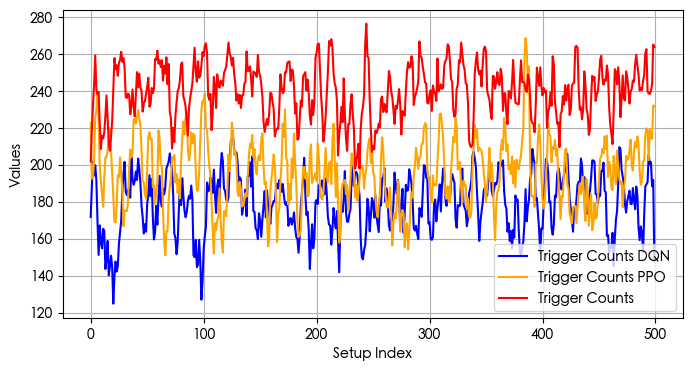

301 0.602
500 1.0
Consensus Time(200 in total) -2.4350666666666676
Trigger Counts -60.45333333333334


In [31]:
import numpy as np
import matplotlib.pyplot as plt
import rl_utils

class Agent:
    def __init__(self, initial_position, index, c_0, c_1, alpha):
        self.position = initial_position
        self.index = index
        self.neighbors = []
        self.last_broadcast_position = self.position
        self.trigger_points = []
        self.u_i = 0
        self.c_0 = c_0
        self.c_1 = c_1
        self.alpha = alpha
        self.trigger_count = 0
        self.consensus_time = None
        self.a = 0.005
         
    def add_neighbor(self, neighbor):
        if neighbor not in self.neighbors:
            self.neighbors.append(neighbor)
            neighbor.neighbors.append(self)

    def is_neighbor(self, agent):
        return agent in self.neighbors
    
    def update_position(self, t, dt):
        e_i = self.last_broadcast_position - self.position
        trigger_condition = np.abs(e_i) - (self.c_0 + self.c_1 * np.exp(- self.alpha * t))
        if trigger_condition >= 0 or t == 0:
            self.u_i = - sum(self.is_neighbor(neighbor) * (self.last_broadcast_position - neighbor.last_broadcast_position) for neighbor in self.neighbors)
            self.position += self.u_i * dt
            self.last_broadcast_position = self.position
            self.trigger_points.append((t, self.position))
            self.trigger_count += 1
        else:
            self.position += self.u_i * dt

        positions = np.array([agent.position for agent in agents])
        max_diff = np.max(positions) - np.min(positions)
        if max_diff <= self.a and self.consensus_time is None:
            self.consensus_time = t
        elif max_diff > self.a:
            self.consensus_time = None

# Parameters
num_agents = 5
num_iterations = 200
dt = 0.1
num_setups = 500
consensus_times = []
trigger_counts = []

consensus_times1 = []
trigger_counts1 = []

consensus_times2 = []
trigger_counts2 = []

# Simulate multiple setups
np.random.seed(0)
for _ in range(num_setups):
    initial_positions = np.random.uniform(-1, 1, num_agents)
    agents = [Agent(pos, i, 0.00057, 7.4, 1.03) for i, pos in enumerate(initial_positions)]
    #agents = [Agent(pos, i, 0.0008, 7.1, 0.48) for i, pos in enumerate(initial_positions)]


    # Define neighbor relationships (static for simplicity)
    agents[0].add_neighbor(agents[1])
    agents[0].add_neighbor(agents[2])
    agents[1].add_neighbor(agents[2])
    agents[2].add_neighbor(agents[3])
    agents[3].add_neighbor(agents[4])

    for t in range(num_iterations):
        for agent in agents:
            agent.update_position(t, dt)

    consensus_achieved = any(agent.consensus_time is not None for agent in agents)
    if consensus_achieved:
        consensus_time = max(agent.consensus_time for agent in agents if agent.consensus_time is not None)
        consensus_times.append(consensus_time)
    else:
        consensus_times.append(num_iterations)

    current_trigger_counts = sum(agent.trigger_count for agent in agents)
    trigger_counts.append(current_trigger_counts)

for _ in range(num_setups):
    initial_positions = np.random.uniform(-1, 1, num_agents)
    #agents = [Agent(pos, i, 0.0001, 0.2499, 0.4669) for i, pos in enumerate(initial_positions)]
    agents = [Agent(pos, i, 0.00026, 5, 0.2) for i, pos in enumerate(initial_positions)]

    # Define neighbor relationships (static for simplicity)
    agents[0].add_neighbor(agents[1])
    agents[0].add_neighbor(agents[2])
    agents[1].add_neighbor(agents[2])
    agents[2].add_neighbor(agents[3])
    agents[3].add_neighbor(agents[4])

    for t in range(num_iterations):
        for agent in agents:
            agent.update_position(t, dt)

    consensus_achieved = any(agent.consensus_time is not None for agent in agents)
    if consensus_achieved:
        consensus_time = max(agent.consensus_time for agent in agents if agent.consensus_time is not None)
        consensus_times1.append(consensus_time)
    else:
        consensus_times1.append(num_iterations)

    current_trigger_counts = sum(agent.trigger_count for agent in agents)
    trigger_counts1.append(current_trigger_counts)


for _ in range(num_setups):
    initial_positions = np.random.uniform(-1, 1, num_agents)
    agents = [Agent(pos, i, 0.0001, 0.2499, 0.4669) for i, pos in enumerate(initial_positions)]
    #agents = [Agent(pos, i, 0.0004, 6, 0.3) for i, pos in enumerate(initial_positions)]

    # Define neighbor relationships (static for simplicity)
    agents[0].add_neighbor(agents[1])
    agents[0].add_neighbor(agents[2])
    agents[1].add_neighbor(agents[2])
    agents[2].add_neighbor(agents[3])
    agents[3].add_neighbor(agents[4])

    for t in range(num_iterations):
        for agent in agents:
            agent.update_position(t, dt)

    consensus_achieved = any(agent.consensus_time is not None for agent in agents)
    if consensus_achieved:
        consensus_time = max(agent.consensus_time for agent in agents if agent.consensus_time is not None)
        consensus_times2.append(consensus_time)
    else:
        consensus_times2.append(num_iterations)

    current_trigger_counts = sum(agent.trigger_count for agent in agents)
    trigger_counts2.append(current_trigger_counts)




# Plotting
plt.figure(figsize=(12, 6))
plt.plot(range(num_setups), consensus_times,  linestyle='-', color='blue', label='Consensus Time DQN')
plt.plot(range(num_setups), consensus_times1,  linestyle='-', color='orange', label='Consensus Time PPO')
plt.plot(range(num_setups), consensus_times2,  linestyle='-', color='red', label='Consensus Time')
plt.xlabel('Setup Index')
plt.ylabel('Values')
plt.title('Consensus Time')
plt.legend()
plt.grid(True)
plt.show()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(range(num_setups), trigger_counts,  linestyle='-', color='blue', label='Trigger Counts DQN')
plt.plot(range(num_setups), trigger_counts1,  linestyle='-', color='orange', label='Trigger Counts PPO')
plt.plot(range(num_setups), trigger_counts2,  linestyle='-', color='red', label='Trigger Counts')
plt.xlabel('Setup Index')
plt.ylabel('Values')
plt.title('Trigger Counts')
plt.legend()
plt.grid(True)
plt.show()

c = 0
t = 0
a = 0
b = 0

current_trigger_counts_m = rl_utils.moving_average(consensus_times, 5)
current_trigger_counts1_m = rl_utils.moving_average(consensus_times1, 5)
current_trigger_counts2_m = rl_utils.moving_average(consensus_times2, 5)
trigger_counts_m = rl_utils.moving_average(trigger_counts, 5)
trigger_counts1_m = rl_utils.moving_average(trigger_counts1, 5)
trigger_counts2_m = rl_utils.moving_average(trigger_counts2, 5)


for i in range(num_setups):
    if current_trigger_counts_m[i] < current_trigger_counts2_m[i]:
        c += 1

    if trigger_counts_m[i] < trigger_counts2_m[i]:
        t += 1

    n = current_trigger_counts_m[i] - current_trigger_counts2_m[i]
    a += n

    m = trigger_counts_m[i] - trigger_counts2_m[i]
    b += m


# Plotting
plt.figure(figsize=(12, 6))
plt.plot(range(num_setups), current_trigger_counts_m,  linestyle='-', color='blue', label='Consensus Time DQN')
plt.plot(range(num_setups), current_trigger_counts1_m,  linestyle='-', color='orange', label='Consensus Time PPO')
plt.plot(range(num_setups), current_trigger_counts2_m,  linestyle='-', color='red', label='Consensus Time')
plt.xlabel('Setup Index')
plt.ylabel('Values')
plt.title('Consensus Time')
plt.legend()
plt.grid(True)
plt.show()



# Plotting
plt.figure(figsize=(8, 4))
plt.plot(range(num_setups), trigger_counts_m,  linestyle='-', color='blue', label='Trigger Counts DQN')
plt.plot(range(num_setups), trigger_counts1_m,  linestyle='-', color='orange', label='Trigger Counts PPO')
plt.plot(range(num_setups), trigger_counts2_m,  linestyle='-', color='red', label='Trigger Counts')
plt.xlabel('Setup Index')
plt.ylabel('Values')
#plt.title('Trigger Counts')
plt.legend()
plt.grid(True)
plt.show()

print(c, c/num_setups)
print(t, t/num_setups)
print('Consensus Time(200 in total)', a/num_setups)
print('Trigger Counts', b/num_setups)

实现了一致性，时间: 79
总触发次数: 196


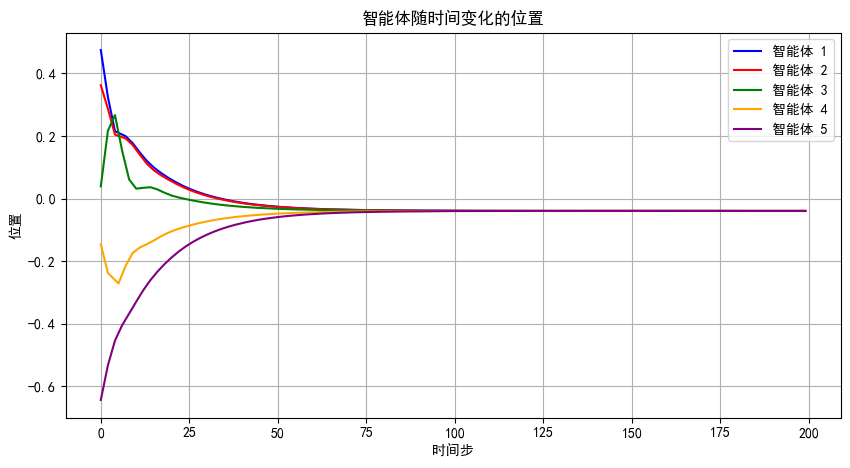

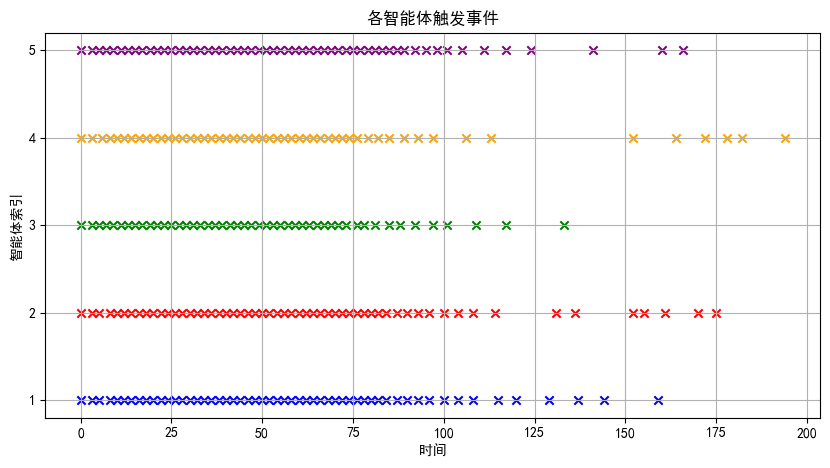

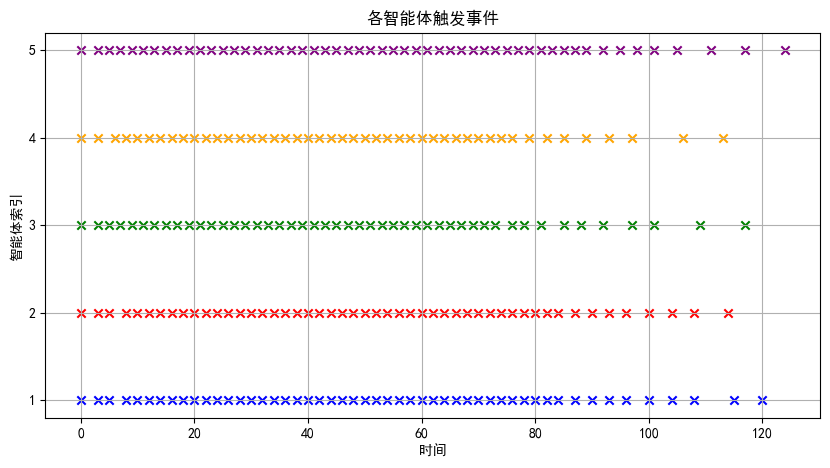

In [57]:
import numpy as np
import matplotlib.pyplot as plt

class Agent:
    def __init__(self, initial_position, index):
        self.position = initial_position
        self.index = index
        self.neighbors = []
        self.last_broadcast_position = self.position  #存储了该智能体最近一次广播的位置
        self.trigger_points = []
        self.u_i = 0
        self.c_0 = 0.0001
        self.c_1 = 0.2499
        self.alpha = 0.4669
        self.trigger_count = 0
        self.consensus_time = None  # 记录实现一致性的时间
        self.a = 0.005
         
    def add_neighbor(self, neighbor):
        if neighbor not in self.neighbors:
            self.neighbors.append(neighbor)
            neighbor.neighbors.append(self)

    def is_neighbor(self, agent):
        return agent in self.neighbors
    
    def update_position(self, t, dt):
        e_i = self.last_broadcast_position - self.position
        trigger_condition = np.abs(e_i) - (self.c_0 + self.c_1 * np.exp(- self.alpha * t))
        
        # 如果事件触发函数大于等于0，则更新位置
        if trigger_condition >= 0 or t == 0:
            self.u_i = - sum(self.is_neighbor(neighbor) * (self.last_broadcast_position - neighbor.last_broadcast_position) for neighbor in self.neighbors)
            self.position += self.u_i * dt
            self.last_broadcast_position = self.position
            #记录触发的相关信息
            self.trigger_points.append((t, self.position))
            self.trigger_count += 1
        else:
            self.position += self.u_i * dt

        # 检查一致性
        positions = np.array([agent.position for agent in agents])
        max_diff = np.max(positions) - np.min(positions)
        if max_diff <= self.a and self.consensus_time is None:
            self.consensus_time = t  # 更新一致性时间
        elif max_diff > self.a:
            self.consensus_time = None  # 失去一致性
            

# 初始化参数和智能体
num_agents = 5
num_iterations = 200
dt = 0.1
np.random.seed(0)
#agents = [Agent(np.random.uniform(-1, 1), i) for i in range(num_agents)]
#initial_positions = np.linspace(-1, 1, num_agents)
initial_positions = [0.55, 0.4, -0.05, -0.1, -0.7]
agents = [Agent(pos, i) for i, pos in enumerate(initial_positions)]  

# 定义邻居关系
agents[0].add_neighbor(agents[1])
agents[0].add_neighbor(agents[2])
agents[1].add_neighbor(agents[2])
agents[2].add_neighbor(agents[3])
agents[3].add_neighbor(agents[4])

L = np.array([[ 2, -1, -1,  0,  0],
              [-1,  2, -1,  0,  0],
              [-1, -1,  3, -1,  0],
              [ 0,  0, -1,  2, -1],
              [ 0,  0,  0, -1,  1]])

# 计算拉普拉斯矩阵的特征值
eigenvalues = np.linalg.eigvalsh(L)
# 谱范数是所有特征值的绝对值中的最大值
spectral_norm = np.max(np.abs(eigenvalues))
# 第二小的特征值，也被称为网络的代数连通性
second_smallest_eigenvalue = np.partition(eigenvalues, 1)[1]


# 运行模拟
positions = np.zeros((num_iterations, num_agents))
for t in range(num_iterations):
    for agent in agents:
        agent.update_position(t, dt)
        positions[t, agent.index] = agent.position

# 检查是否实现了一致性并输出结果
consensus_achieved = any(agent.consensus_time is not None for agent in agents)
if consensus_achieved:
    consensus_times = [agent.consensus_time for agent in agents if agent.consensus_time is not None]
    print(f"实现了一致性，时间: {max(consensus_times)}")
else:
    print("没有实现一致性")

trigger_counts = sum(len([point for point in agent.trigger_points if point[0] <= max(consensus_times)]) for agent in agents)
print(f"总触发次数: {trigger_counts}")


# 手动指定每个智能体的颜色
colors = ['blue', 'red', 'green', 'orange', 'purple']  # 每个智能体的颜色

# 绘制结果图
plt.figure(figsize=(10, 5))
for i, agent in enumerate(agents):
    plt.plot(positions[:, i], label=f'智能体 {i+1}', color=colors[i])
plt.xlabel('时间步')
plt.ylabel('位置')
plt.title('智能体随时间变化的位置')
plt.legend()
plt.grid(True)
plt.show()



# 绘制触发事件图，确保智能体的触发事件颜色与其位置图中的颜色相匹配
plt.figure(figsize=(10, 5))
# 收集所有智能体的触发时间点和对应的索引
trigger_events = []
for i, agent in enumerate(agents):
    for t, _ in agent.trigger_points:
        trigger_events.append((t, i + 1, colors[i]))  # 存储时间、智能体索引和颜色
# 按触发时间排序
trigger_events.sort()
# 绘制触发事件
for t, i, color in trigger_events:
    plt.scatter(t, i, marker='x', color=color)  # 使用相应颜色绘制触发事件
plt.xlabel('时间')
plt.ylabel('智能体索引')
plt.title('各智能体触发事件')
plt.yticks(range(1, num_agents + 1))  # 设置y轴刻度以匹配智能体的索引
plt.grid(True)
plt.show()


# 创建自定义的时间数组
time = 125
custom_time = np.arange(num_iterations) * dt

# 截取前50个时间步的数据
custom_time = custom_time[:time]

# 绘制触发事件图，使用截取后的时间数组
plt.figure(figsize=(10, 5))
# 收集所有智能体的触发时间点和对应的索引以及颜色
trigger_events = []
for i, agent in enumerate(agents):
    for t, _ in agent.trigger_points:
        if t < time:  # 仅保留时间步前50的触发事件数据
            trigger_events.append((custom_time[t], i + 1, colors[i]))  # 存储时间、智能体索引和颜色
# 按触发时间排序
trigger_events.sort()
# 绘制触发事件
for t, i, color in trigger_events:
    plt.scatter(t * 10, i, marker='x', color=color)  # 使用之前生成的颜色映射绘制触发事件，保持颜色一致
plt.xlabel('时间')
plt.ylabel('智能体索引')
plt.title('各智能体触发事件')
plt.yticks(range(1, num_agents + 1))  # 设置y轴刻度以匹配智能体的索引
plt.grid(True)
plt.show()


# 解决中文显示问题
plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体为黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像时负号 '-' 显示为方块的问题

plt.show()

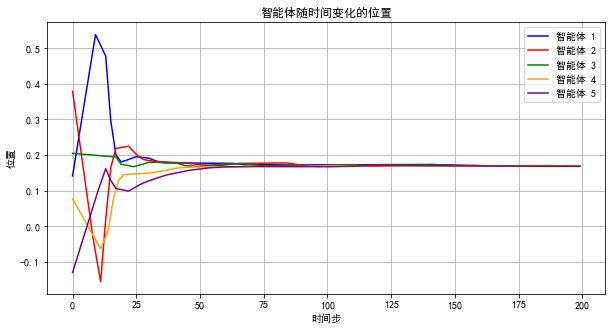

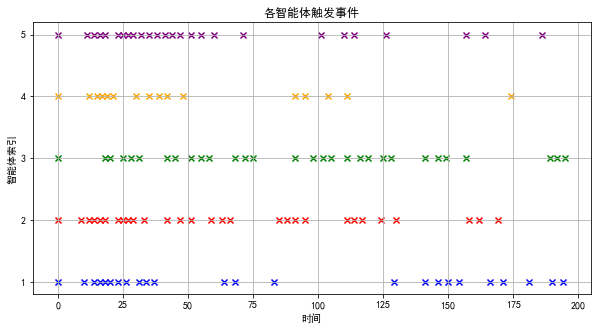

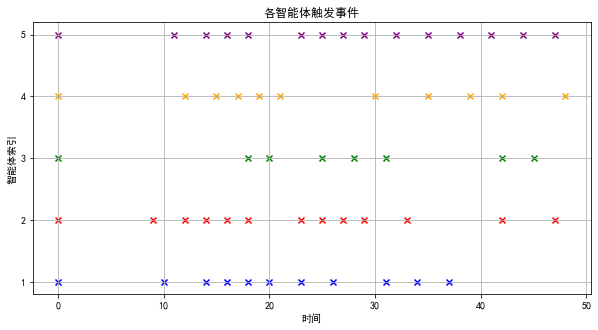

In [6]:
#自己改进的触发函数

import numpy as np
import matplotlib.pyplot as plt

class Agent:
    def __init__(self, initial_position, index):
        self.position = initial_position
        self.index = index
        self.neighbors = []
        self.last_broadcast_position = self.position  #存储了该智能体最近一次广播的位置
        self.trigger_points = []
        self.u_i = 0
        self.c_0 = 0.0001
        self.c_1 = 0.2499
        self.alpha = 0.4669
        self.si = 0.001
         
    def add_neighbor(self, neighbor):
        if neighbor not in self.neighbors:
            self.neighbors.append(neighbor)
            neighbor.neighbors.append(self)

    def is_neighbor(self, agent):
        return agent in self.neighbors
    
    def update_position(self, t, dt):
        e_i = self.last_broadcast_position - self.position
        mu = (self.si + (1 - self.si) * (1 - np.exp(-self.si * t)))
        trigger_condition = mu * np.abs(e_i) - (self.c_0 + self.c_1 * np.exp(- self.alpha * t))
        
        # 如果事件触发函数大于等于0，则更新位置
        if trigger_condition >= 0 or t == 0:
            self.u_i = - sum(self.is_neighbor(neighbor) * (self.last_broadcast_position - neighbor.last_broadcast_position) for neighbor in self.neighbors)
            self.position += self.u_i * dt
            self.last_broadcast_position = self.position
            #记录触发的相关信息
            self.trigger_points.append((t, self.position))
        else:
            self.position += self.u_i * dt
            

# 初始化参数和智能体
num_agents = 5
num_iterations = 200
dt = 0.1
np.random.seed(0)
agents = [Agent(np.random.uniform(-1, 1), i) for i in range(num_agents)]

# 定义邻居关系
agents[0].add_neighbor(agents[1])
agents[0].add_neighbor(agents[2])
agents[1].add_neighbor(agents[2])
agents[2].add_neighbor(agents[3])
agents[3].add_neighbor(agents[4])

L = np.array([[ 2, -1, -1,  0,  0],
              [-1,  2, -1,  0,  0],
              [-1, -1,  3, -1,  0],
              [ 0,  0, -1,  2, -1],
              [ 0,  0,  0, -1,  1]])

# 计算拉普拉斯矩阵的特征值
eigenvalues = np.linalg.eigvalsh(L)
# 谱范数是所有特征值的绝对值中的最大值
spectral_norm = np.max(np.abs(eigenvalues))
# 第二小的特征值，也被称为网络的代数连通性
second_smallest_eigenvalue = np.partition(eigenvalues, 1)[1]


# 运行模拟
positions = np.zeros((num_iterations, num_agents))
for t in range(num_iterations):
    for agent in agents:
        agent.update_position(t, dt)
        positions[t, agent.index] = agent.position


# 手动指定每个智能体的颜色
colors = ['blue', 'red', 'green', 'orange', 'purple']  # 每个智能体的颜色

# 绘制结果图
plt.figure(figsize=(10, 5))
for i, agent in enumerate(agents):
    plt.plot(positions[:, i], label=f'智能体 {i+1}', color=colors[i])
plt.xlabel('时间步')
plt.ylabel('位置')
plt.title('智能体随时间变化的位置')
plt.legend()
plt.grid(True)
plt.show()



# 绘制触发事件图，确保智能体的触发事件颜色与其位置图中的颜色相匹配
plt.figure(figsize=(10, 5))
# 收集所有智能体的触发时间点和对应的索引
trigger_events = []
for i, agent in enumerate(agents):
    for t, _ in agent.trigger_points:
        trigger_events.append((t, i + 1, colors[i]))  # 存储时间、智能体索引和颜色
# 按触发时间排序
trigger_events.sort()
# 绘制触发事件
for t, i, color in trigger_events:
    plt.scatter(t, i, marker='x', color=color)  # 使用相应颜色绘制触发事件
plt.xlabel('时间')
plt.ylabel('智能体索引')
plt.title('各智能体触发事件')
plt.yticks(range(1, num_agents + 1))  # 设置y轴刻度以匹配智能体的索引
plt.grid(True)
plt.show()


# 创建自定义的时间数组
time = 50
custom_time = np.arange(num_iterations) * dt

# 截取前50个时间步的数据
custom_time = custom_time[:time]

# 绘制触发事件图，使用截取后的时间数组
plt.figure(figsize=(10, 5))
# 收集所有智能体的触发时间点和对应的索引以及颜色
trigger_events = []
for i, agent in enumerate(agents):
    for t, _ in agent.trigger_points:
        if t < time:  # 仅保留时间步前50的触发事件数据
            trigger_events.append((custom_time[t], i + 1, colors[i]))  # 存储时间、智能体索引和颜色
# 按触发时间排序
trigger_events.sort()
# 绘制触发事件
for t, i, color in trigger_events:
    plt.scatter(t * 10, i, marker='x', color=color)  # 使用之前生成的颜色映射绘制触发事件，保持颜色一致
plt.xlabel('时间')
plt.ylabel('智能体索引')
plt.title('各智能体触发事件')
plt.yticks(range(1, num_agents + 1))  # 设置y轴刻度以匹配智能体的索引
plt.grid(True)
plt.show()


# 解决中文显示问题
plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体为黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像时负号 '-' 显示为方块的问题

plt.show()

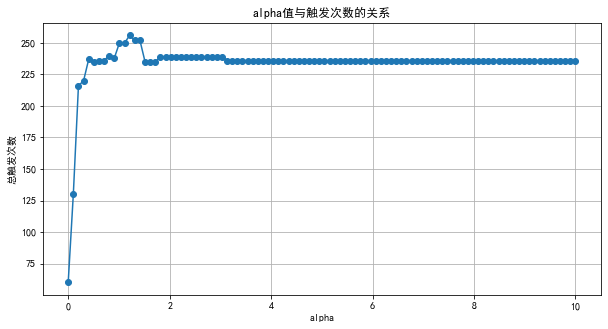

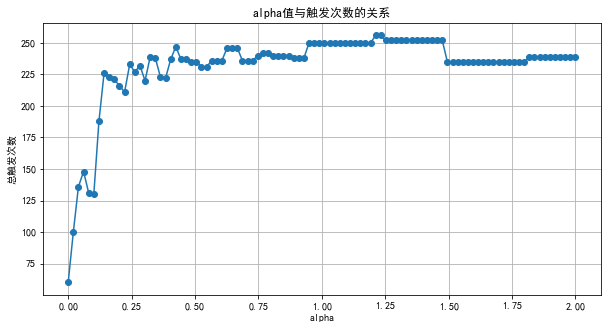

In [3]:
import numpy as np
import matplotlib.pyplot as plt

class Agent:
    def __init__(self, initial_position, index):
        self.position = initial_position
        self.index = index
        self.neighbors = []
        self.last_broadcast_position = self.position  #存储了该智能体最近一次广播的位置
        self.trigger_points = []
        self.u_i = 0
        self.c_0 = 0.0001
        self.c_1 = 0.2499
        self.alpha = 0.6
         
    def add_neighbor(self, neighbor):
        if neighbor not in self.neighbors:
            self.neighbors.append(neighbor)
            neighbor.neighbors.append(self)

    def is_neighbor(self, agent):
        return agent in self.neighbors
    
    def update_position(self, t, dt, alpha):
        e_i = self.last_broadcast_position - self.position
        trigger_condition = np.abs(e_i) - (self.c_0 + self.c_1 * np.exp(- alpha * t))
        
        # 如果事件触发函数大于等于0，则更新位置
        if trigger_condition >= 0 or t == 0:
            self.u_i = - sum(self.is_neighbor(neighbor) * (self.last_broadcast_position - neighbor.last_broadcast_position) for neighbor in self.neighbors)
            self.position += self.u_i * dt
            self.last_broadcast_position = self.position
            #记录触发的相关信息
            self.trigger_points.append((t, self.position))
        else:
            self.position += self.u_i * dt

def run_simulation(alpha):
    # 初始化参数和智能体
    num_agents = 5
    num_iterations = 200
    dt = 0.1
    np.random.seed(0)
    agents = [Agent(np.random.uniform(-1, 1), i) for i in range(num_agents)]

    # 定义邻居关系
    agents[0].add_neighbor(agents[1])
    agents[0].add_neighbor(agents[2])
    agents[1].add_neighbor(agents[2])
    agents[2].add_neighbor(agents[3])
    agents[3].add_neighbor(agents[4])

    # 运行模拟
    for t in range(num_iterations):
        for agent in agents:
            agent.update_position(t, dt, alpha)

    # 统计触发次数
    total_triggers = sum(len(agent.trigger_points) for agent in agents)
    return total_triggers

# 设置alpha的不同值
alphas = np.linspace(0, 10, 100)
triggers = []

# 对每个alpha值运行模拟并收集触发次数
for alpha in alphas:
    triggers.append(run_simulation(alpha))

# 绘制结果
plt.figure(figsize=(10, 5))
plt.plot(alphas, triggers, marker='o')
plt.xlabel('alpha')
plt.ylabel('总触发次数')
plt.title('alpha值与触发次数的关系')
plt.grid(True)


# 设置alpha的不同值
alphas = np.linspace(0, 2, 100)
triggers = []

# 对每个alpha值运行模拟并收集触发次数
for alpha in alphas:
    triggers.append(run_simulation(alpha))

# 绘制结果
plt.figure(figsize=(10, 5))
plt.plot(alphas, triggers, marker='o')
plt.xlabel('alpha')
plt.ylabel('总触发次数')
plt.title('alpha值与触发次数的关系')
plt.grid(True)
plt.show()


/var/folders/8l/jgps2kqd6v58l257c5xc_2h00000gn/T/ipykernel_53091/321796013.py:90: UserWarning: Glyph 24635 (\N{CJK UNIFIED IDEOGRAPH-603B}) missing from current font.
  plt.tight_layout()
/var/folders/8l/jgps2kqd6v58l257c5xc_2h00000gn/T/ipykernel_53091/321796013.py:90: UserWarning: Glyph 35302 (\N{CJK UNIFIED IDEOGRAPH-89E6}) missing from current font.
  plt.tight_layout()
/var/folders/8l/jgps2kqd6v58l257c5xc_2h00000gn/T/ipykernel_53091/321796013.py:90: UserWarning: Glyph 21457 (\N{CJK UNIFIED IDEOGRAPH-53D1}) missing from current font.
  plt.tight_layout()
/var/folders/8l/jgps2kqd6v58l257c5xc_2h00000gn/T/ipykernel_53091/321796013.py:90: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  plt.tight_layout()
/var/folders/8l/jgps2kqd6v58l257c5xc_2h00000gn/T/ipykernel_53091/321796013.py:90: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  plt.tight_layout()
/var/folders/8l/jgps2kqd6v58l257c5xc_2h00000gn/T/ipykernel_5

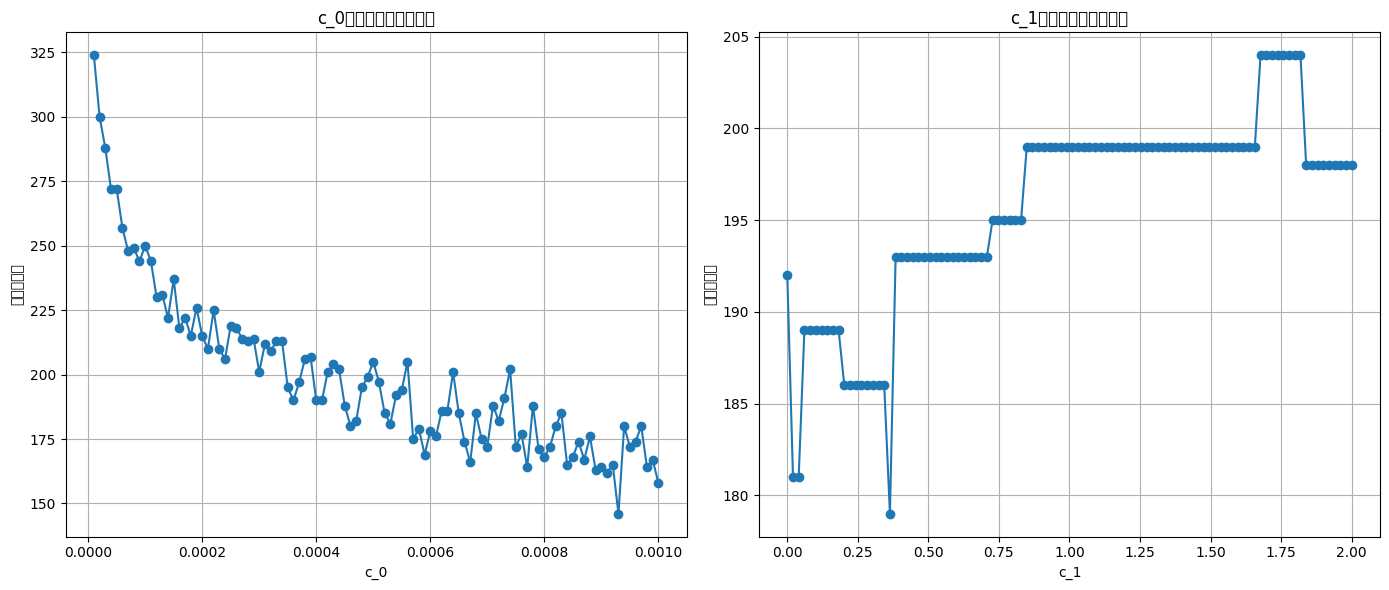

In [3]:
import numpy as np
import matplotlib.pyplot as plt

class Agent:
    def __init__(self, initial_position, index, c_0=0.00049, c_1=1.2, alpha=1.4):
        self.position = initial_position
        self.index = index
        self.neighbors = []
        self.last_broadcast_position = self.position  #存储了该智能体最近一次广播的位置
        self.trigger_points = []
        self.u_i = 0
        self.c_0 = c_0
        self.c_1 = c_1
        self.alpha = alpha
         
    def add_neighbor(self, neighbor):
        if neighbor not in self.neighbors:
            self.neighbors.append(neighbor)
            neighbor.neighbors.append(self)

    def is_neighbor(self, agent):
        return agent in self.neighbors
    
    def update_position(self, t, dt):
        e_i = self.last_broadcast_position - self.position
        trigger_condition = np.abs(e_i) - (self.c_0 + self.c_1 * np.exp(- self.alpha * t))
        
        # 如果事件触发函数大于等于0，则更新位置
        if trigger_condition >= 0 or t == 0:
            self.u_i = - sum(self.is_neighbor(neighbor) * (self.last_broadcast_position - neighbor.last_broadcast_position) for neighbor in self.neighbors)
            self.position += self.u_i * dt
            self.last_broadcast_position = self.position
            #记录触发的相关信息
            self.trigger_points.append((t, self.position))
        else:
            self.position += self.u_i * dt

def run_simulation(parameter, changing_param='c_0'):
    num_agents = 5
    num_iterations = 200
    dt = 0.1
    np.random.seed(0)
    
    if changing_param == 'c_0':
        agents = [Agent(np.random.uniform(-1, 1), i, c_0=parameter) for i in range(num_agents)]
    else:  # changing_param == 'c_1'
        agents = [Agent(np.random.uniform(-1, 1), i, c_1=parameter) for i in range(num_agents)]
        
    # 定义邻居关系
    agents[0].add_neighbor(agents[1])
    agents[0].add_neighbor(agents[2])
    agents[1].add_neighbor(agents[2])
    agents[2].add_neighbor(agents[3])
    agents[3].add_neighbor(agents[4])

    # 运行模拟
    for t in range(num_iterations):
        for agent in agents:
            agent.update_position(t, dt)
            
    # 统计触发次数
    total_triggers = sum(len(agent.trigger_points) for agent in agents)
    return total_triggers

# 设置c_0和c_1的不同值
c0_values = np.linspace(0.00001, 0.001, 100)
c1_values = np.linspace(0.001, 2, 100)

# 收集触发次数
triggers_c0 = [run_simulation(c_0, changing_param='c_0') for c_0 in c0_values]
triggers_c1 = [run_simulation(c_1, changing_param='c_1') for c_1 in c1_values]

# 绘制c_0的影响
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(c0_values, triggers_c0, marker='o')
plt.xlabel('c_0')
plt.ylabel('总触发次数')
plt.title('c_0值与触发次数的关系')
plt.grid(True)

# 绘制c_1的影响
plt.subplot(1, 2, 2)
plt.plot(c1_values, triggers_c1, marker='o')
plt.xlabel('c_1')
plt.ylabel('总触发次数')
plt.title('c_1值与触发次数的关系')
plt.grid(True)

plt.tight_layout()
plt.show()


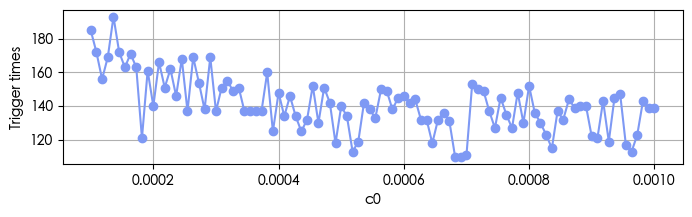

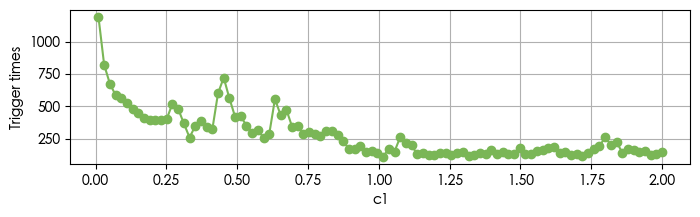

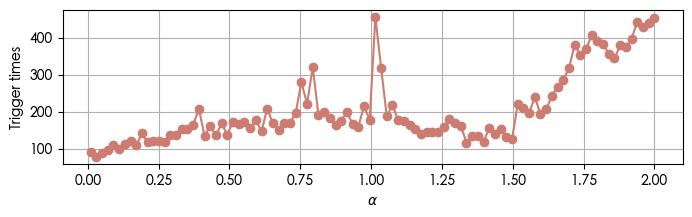

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

# 设置中文字体为macOS中的常见中文字体
rcParams['font.sans-serif'] = ['PingFang SC', 'Heiti TC', 'Arial Unicode MS']
rcParams['axes.unicode_minus'] = False  # 解决负号无法显示的问题

class Agent:
    def __init__(self, initial_position, index, c_0=0.00068, c_1=1.2, alpha=1.4):
        self.position = initial_position
        self.index = index
        self.neighbors = []
        self.last_broadcast_position = self.position  # 存储了该智能体最近一次广播的位置
        self.trigger_points = []
        self.u_i = 0
        self.c_0 = c_0
        self.c_1 = c_1
        self.alpha = alpha
        self.trigger_count = 0

    def add_neighbor(self, neighbor):
        if neighbor not in self.neighbors:
            self.neighbors.append(neighbor)
            neighbor.neighbors.append(self)

    def update_position(self, t, dt):
        e_i = self.last_broadcast_position - self.position
        trigger_condition = np.abs(e_i) - (self.c_0 + self.c_1 * np.exp(- self.alpha * t))
        
        # 如果事件触发函数大于等于0，则更新位置
        if trigger_condition >= 0 or t == 0:
            self.u_i = - sum((self.last_broadcast_position - neighbor.last_broadcast_position) for neighbor in self.neighbors)
            self.position += self.u_i * dt
            self.last_broadcast_position = self.position
            # 记录触发的相关信息
            self.trigger_points.append((t, self.position))
            self.trigger_count += 1
        else:
            self.position += self.u_i * dt

# 定义邻居关系
def initialize_agents_and_neighbors(c_0, c_1, alpha):
    initial_positions = [0.55, 0.4, -0.05, -0.1, -0.7]
    agents = [Agent(pos, i, c_0=c_0, c_1=c_1, alpha=alpha) for i, pos in enumerate(initial_positions)]
    agents[0].add_neighbor(agents[1])
    agents[0].add_neighbor(agents[2])
    agents[1].add_neighbor(agents[2])
    agents[2].add_neighbor(agents[3])
    agents[3].add_neighbor(agents[4])
    return agents

# 运行模拟
def run_simulation(c_0, c_1, alpha, num_iterations=20, dt=0.001):
    agents = initialize_agents_and_neighbors(c_0, c_1, alpha)
    t = 0
    index = 0
    while index < int(num_iterations / dt):
        for agent in agents:
            agent.update_position(t, dt)
        t += dt
        index += 1
    trigger_counts = sum(agent.trigger_count for agent in agents)
    return trigger_counts

# 生成参数变化图
def plot_parameter_effects():
    num_iterations = 20
    dt = 0.001

    # c0变化，从0.0001到0.001
    c0_values = np.linspace(0.0001, 0.001, 100)
    trigger_counts_c0 = [run_simulation(c_0=c0, c_1=1.2, alpha=1.4, num_iterations=num_iterations, dt=dt) for c0 in c0_values]

    # c1变化，从0.01到2
    c1_values = np.linspace(0.01, 2, 100)
    trigger_counts_c1 = [run_simulation(c_0=0.00068, c_1=c1, alpha=1.4, num_iterations=num_iterations, dt=dt) for c1 in c1_values]

    # alpha变化，从0.01到2
    alpha_values = np.linspace(0.01, 2, 100)
    trigger_counts_alpha = [run_simulation(c_0=0.00068, c_1=1.2, alpha=alpha, num_iterations=num_iterations, dt=dt) for alpha in alpha_values]
    
    # 设置RGB颜色
    color_c0 = (126/255, 153/255, 244/255)  # 对应 RGB: 126, 153, 244
    color_c1 = (122/255, 182/255, 86/255)   # 对应 RGB: 122, 182, 86
    color_alpha = (204/255, 124/255, 113/255)  # 对应 RGB: 204, 124, 113

    # 绘制c0变化的触发次数图
    plt.figure(figsize=(8, 2))
    plt.plot(c0_values, trigger_counts_c0, marker='o', color=color_c0)
    plt.xlabel('c0')
    plt.ylabel('Trigger times')
    plt.grid(True)

    # 绘制c1变化的触发次数图
    plt.figure(figsize=(8, 2))
    plt.plot(c1_values, trigger_counts_c1, marker='o', color=color_c1)
    plt.xlabel('c1')
    plt.ylabel('Trigger times')
    plt.grid(True)

    # 绘制alpha变化的触发次数图
    plt.figure(figsize=(8, 2))
    plt.plot(alpha_values, trigger_counts_alpha, marker='o', color=color_alpha)
    plt.xlabel('$\\alpha$')
    plt.ylabel('Trigger times')
    plt.grid(True)
    

    plt.show()

# 运行绘制图函数
plot_parameter_effects()

c0变化时触发次数最少的值: 0.0006818181818181819, 对应的触发次数: 110
c1变化时触发次数最少的值: 2.0, 对应的触发次数: 124
alpha变化时触发次数最少的值: 0.0301010101010101, 对应的触发次数: 81


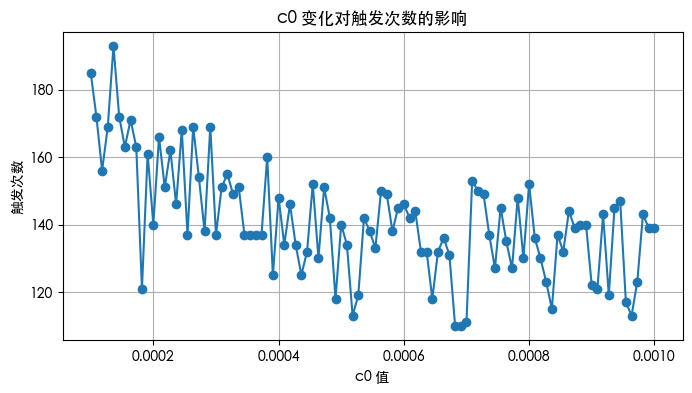

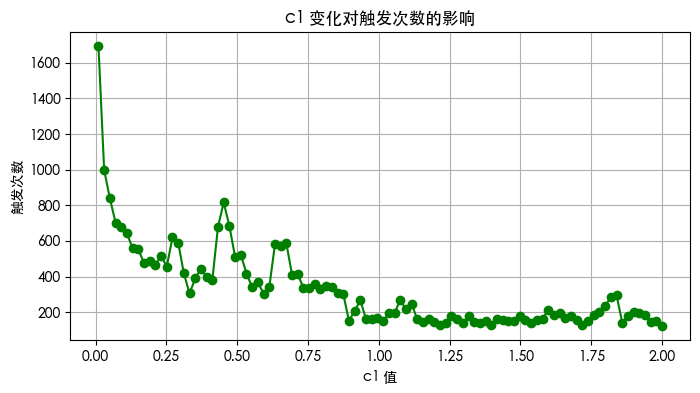

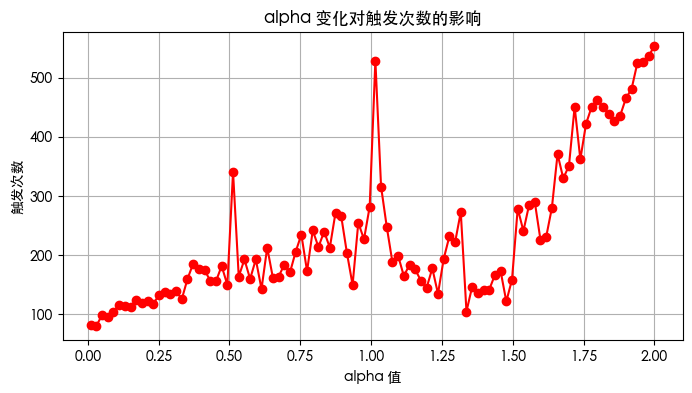

In [23]:
# 生成参数变化图，并输出触发次数最少的对应参数值
def plot_parameter_effects():
    num_iterations = 20
    dt = 0.001

    # c0变化，从0.0001到0.001
    c0_values = np.linspace(0.0001, 0.001, 100)
    trigger_counts_c0 = [run_simulation(c_0=c0, c_1=1.2, alpha=1.4, num_iterations=num_iterations, dt=dt) for c0 in c0_values]
    min_trigger_c0 = c0_values[np.argmin(trigger_counts_c0)]  # 找到触发次数最少的c0值
    print(f"c0变化时触发次数最少的值: {min_trigger_c0}, 对应的触发次数: {min(trigger_counts_c0)}")

    # c1变化，从0.01到2
    c1_values = np.linspace(0.01, 2, 100)
    trigger_counts_c1 = [run_simulation(c_0=0.00049, c_1=c1, alpha=1.4, num_iterations=num_iterations, dt=dt) for c1 in c1_values]
    min_trigger_c1 = c1_values[np.argmin(trigger_counts_c1)]  # 找到触发次数最少的c1值
    print(f"c1变化时触发次数最少的值: {min_trigger_c1}, 对应的触发次数: {min(trigger_counts_c1)}")

    # alpha变化，从0.01到2
    alpha_values = np.linspace(0.01, 2, 100)
    trigger_counts_alpha = [run_simulation(c_0=0.00049, c_1=1.2, alpha=alpha, num_iterations=num_iterations, dt=dt) for alpha in alpha_values]
    min_trigger_alpha = alpha_values[np.argmin(trigger_counts_alpha)]  # 找到触发次数最少的alpha值
    print(f"alpha变化时触发次数最少的值: {min_trigger_alpha}, 对应的触发次数: {min(trigger_counts_alpha)}")

    # 绘制c0变化的触发次数图
    plt.figure(figsize=(8, 4))
    plt.plot(c0_values, trigger_counts_c0, marker='o')
    plt.xlabel('c0 值')
    plt.ylabel('触发次数')
    plt.title('c0 变化对触发次数的影响')
    plt.grid(True)

    # 绘制c1变化的触发次数图
    plt.figure(figsize=(8, 4))
    plt.plot(c1_values, trigger_counts_c1, marker='o', color='green')
    plt.xlabel('c1 值')
    plt.ylabel('触发次数')
    plt.title('c1 变化对触发次数的影响')
    plt.grid(True)

    # 绘制alpha变化的触发次数图
    plt.figure(figsize=(8, 4))
    plt.plot(alpha_values, trigger_counts_alpha, marker='o', color='red')
    plt.xlabel('alpha 值')
    plt.ylabel('触发次数')
    plt.title('alpha 变化对触发次数的影响')
    plt.grid(True)

    plt.show()

# 运行绘制图函数并输出最少触发次数的参数值
plot_parameter_effects()

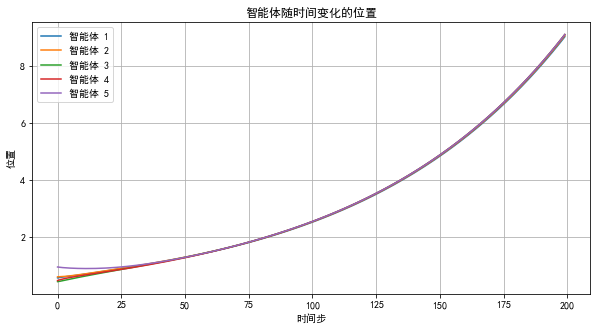

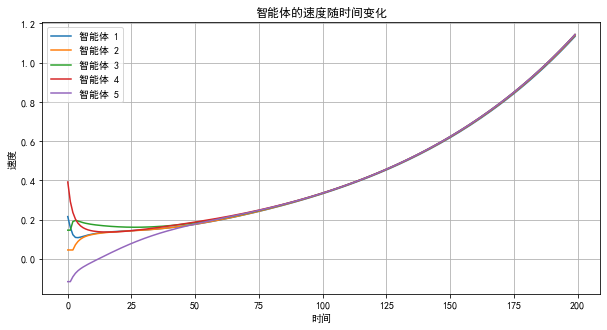

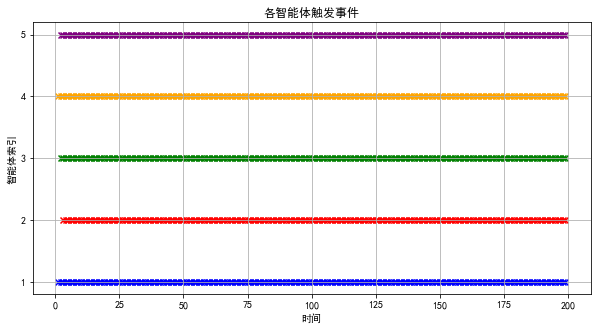

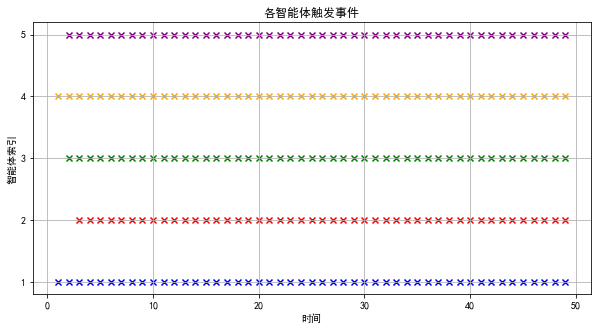

In [65]:
import numpy as np
import matplotlib.pyplot as plt

class Agent:
    def __init__(self, initial_position, initial_velocity, index):
        self.position = initial_position
        self.velocity = initial_velocity
        self.index = index
        self.neighbors = []
        self.last_broadcast_position = self.position  #存储了该智能体最近一次广播的位置
        self.last_broadcast_velocity = self.velocity
        self.trigger_points = []
        self.c_0 = 0.0001
        self.c_1 = 0.2499
        self.alpha = 0.4669
        self.mu = 2
        self.last_event_time = 0  # 初始化上一次事件触发的时间为0
         
    def add_neighbor(self, neighbor):
        if neighbor not in self.neighbors:
            self.neighbors.append(neighbor)
            neighbor.neighbors.append(self)

    def is_neighbor(self, agent):
        return agent in self.neighbors
    
    
    def update_position(self, t, dt):
        time_since_last_event = t - self.last_event_time
        estimated_position = self.last_broadcast_position + time_since_last_event * self.last_broadcast_velocity
        position_error = estimated_position - self.position
        e_i_velocity = self.last_broadcast_velocity - self.velocity
        trigger_condition = np.linalg.norm([position_error, self.mu * e_i_velocity]) - (self.c_0 + self.c_1 * np.exp(-self.alpha * t))
        
        # 如果事件触发函数大于等于0，则更新位置
        if trigger_condition >= 0:
            u_i = - sum(self.is_neighbor(neighbor) * (self.last_broadcast_position - neighbor.last_broadcast_position) for neighbor in self.neighbors) \
                - self.mu * sum(self.is_neighbor(neighbor) * (self.last_broadcast_velocity - neighbor.last_broadcast_velocity) for neighbor in self.neighbors)

            self.velocity += u_i * dt
            self.last_broadcast_position = self.position
            self.last_broadcast_velocity = self.velocity
            self.last_event_time = t
            #记录触发的相关信息
            self.trigger_points.append((t, self.velocity))

        self.position += self.velocity * dt
        #print(- sum(self.is_neighbor(neighbor) * (self.last_broadcast_position - neighbor.last_broadcast_position) for neighbor in self.neighbors))
        #print(- self.mu * sum(self.is_neighbor(neighbor) * (self.last_broadcast_velocity - neighbor.last_broadcast_velocity) for neighbor in self.neighbors))
        #print()



# 初始化参数和智能体
num_agents = 5
num_iterations = 200
dt = 0.1
np.random.seed(0)
agents = [Agent(np.random.uniform(0, 1), np.random.uniform(-0.5, 0.5), i) for i in range(num_agents)]

# 定义邻居关系
agents[0].add_neighbor(agents[1])
agents[0].add_neighbor(agents[2])
agents[1].add_neighbor(agents[2])
agents[2].add_neighbor(agents[3])
agents[3].add_neighbor(agents[4])

L = np.array([[ 2, -1, -1,  0,  0],
              [-1,  2, -1,  0,  0],
              [-1, -1,  3, -1,  0],
              [ 0,  0, -1,  2, -1],
              [ 0,  0,  0, -1,  1]])

# 计算拉普拉斯矩阵的特征值
eigenvalues = np.linalg.eigvalsh(L)
# 谱范数是所有特征值的绝对值中的最大值
spectral_norm = np.max(np.abs(eigenvalues))
# 第二小的特征值，也被称为网络的代数连通性
second_smallest_eigenvalue = np.partition(eigenvalues, 1)[1]


# 运行模拟
positions = np.zeros((num_iterations, num_agents))
velocities = np.zeros((num_iterations, num_agents))
for t in range(num_iterations):
    for agent in agents:
        agent.update_position(t, dt)
        positions[t, agent.index] = agent.position
        velocities[t, agent.index] = agent.velocity

colors = ['blue', 'red', 'green', 'orange', 'purple']  # 每个智能体的颜色
# 绘制结果图
plt.figure(figsize=(10, 5))
for i, agent in enumerate(agents):
    plt.plot(positions[:, i], label=f'智能体 {i+1}')
plt.xlabel('时间步')
plt.ylabel('位置')
plt.title('智能体随时间变化的位置')
plt.legend()
plt.grid(True)

plt.figure(figsize=(10, 5))
for i, agent in enumerate(agents):
    plt.plot(velocities[:, i], label=f'智能体 {i+1}')
plt.xlabel('时间')
plt.ylabel('速度')
plt.title('智能体的速度随时间变化')
plt.legend()
plt.grid(True)


# 绘制触发事件图，确保智能体的触发事件颜色与其位置图中的颜色相匹配
plt.figure(figsize=(10, 5))
# 收集所有智能体的触发时间点和对应的索引
trigger_events = []
for i, agent in enumerate(agents):
    for t, _ in agent.trigger_points:
        trigger_events.append((t, i + 1, colors[i]))  # 存储时间、智能体索引和颜色
# 按触发时间排序
trigger_events.sort()
# 绘制触发事件
for t, i, color in trigger_events:
    plt.scatter(t, i, marker='x', color=color)  # 使用相应颜色绘制触发事件
plt.xlabel('时间')
plt.ylabel('智能体索引')
plt.title('各智能体触发事件')
plt.yticks(range(1, num_agents + 1))  # 设置y轴刻度以匹配智能体的索引
plt.grid(True)
plt.show()


# 创建自定义的时间数组
time = 50
custom_time = np.arange(num_iterations) * dt

# 截取前50个时间步的数据
custom_time = custom_time[:time]

# 绘制触发事件图，使用截取后的时间数组
plt.figure(figsize=(10, 5))
# 收集所有智能体的触发时间点和对应的索引以及颜色
trigger_events = []
for i, agent in enumerate(agents):
    for t, _ in agent.trigger_points:
        if t < time:  # 仅保留时间步前50的触发事件数据
            trigger_events.append((custom_time[t], i + 1, colors[i]))  # 存储时间、智能体索引和颜色
# 按触发时间排序
trigger_events.sort()
# 绘制触发事件
for t, i, color in trigger_events:
    plt.scatter(t * 10, i, marker='x', color=color)  # 使用之前生成的颜色映射绘制触发事件，保持颜色一致
plt.xlabel('时间')
plt.ylabel('智能体索引')
plt.title('各智能体触发事件')
plt.yticks(range(1, num_agents + 1))  # 设置y轴刻度以匹配智能体的索引
plt.grid(True)
plt.show()


# 解决中文显示问题
plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体为黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像时负号 '-' 显示为方块的问题

plt.show()